In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/cleaned_spy_options.csv'


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

Mounted at /content/drive


In [ ]:

data = pd.read_csv(data_path)

print(f"Data shape: {data.shape}")
print("\nFirst 5 rows:")
print(data.head())

print("\nData types:")
print(data.dtypes)
print("\nMissing values:")
print(data.isna().sum())

Data shape: (5217236, 6)

First 5 rows:
         date      exdate  strike_price cp_flag  underlying_price  \
0  2017-08-31  2017-09-11        2075.0       P           2471.65   
1  2017-08-31  2017-09-11        2100.0       P           2471.65   
2  2017-08-31  2017-09-11        2130.0       P           2471.65   
3  2017-08-31  2017-09-11        2220.0       P           2471.65   
4  2017-08-31  2017-09-11        2235.0       P           2471.65   

   impl_volatility  
0         0.334710  
1         0.333985  
2         0.307310  
3         0.252611  
4         0.243809  

Data types:
date                 object
exdate               object
strike_price        float64
cp_flag              object
underlying_price    float64
impl_volatility     float64
dtype: object

Missing values:
date                0
exdate              0
strike_price        0
cp_flag             0
underlying_price    0
impl_volatility     0
dtype: int64


In [ ]:

data['date'] = pd.to_datetime(data['date'])
data['exdate'] = pd.to_datetime(data['exdate'])
data['time_to_expiry'] = (data['exdate'] - data['date']).dt.days
data['strike_price_normalized'] = data['strike_price']
data['moneyness'] = data['strike_price_normalized'] / data['underlying_price']
data = data.dropna(subset=['impl_volatility'])
print(f"Data shape after removing missing values: {data.shape}")

duplicate_count = data.duplicated(subset=['date', 'exdate', 'strike_price', 'cp_flag']).sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    data = data.drop_duplicates(subset=['date', 'exdate', 'strike_price', 'cp_flag'])
    print(f"Data shape after removing duplicates: {data.shape}")

data = data.sort_values(by=['date', 'exdate', 'strike_price', 'cp_flag'])

unique_dates = data['date'].unique()
print(f"Number of unique trading dates: {len(unique_dates)}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")

Data shape after removing missing values: (5217236, 9)
Number of duplicate rows: 0
Number of unique trading dates: 1510
Date range: 2017-08-31 00:00:00 to 2023-08-31 00:00:00


In [ ]:
moneyness_stats = data['moneyness'].describe()
print("Raw moneyness statistics:")
print(moneyness_stats)

Raw moneyness statistics:
count    5.217236e+06
mean     9.448005e-01
std      1.458966e-01
min      2.086350e-02
25%      8.951796e-01
50%      9.755151e-01
75%      1.020517e+00
max      2.292405e+00
Name: moneyness, dtype: float64


In [ ]:
def get_expiry_bucket(days):
    if days <= 7:
        return 7
    elif days <= 30:
        return 30
    elif days <= 60:
        return 60
    elif days <= 90:
        return 90
    elif days <= 180:
        return 180
    else:
        return 365

data['expiry_bucket'] = data['time_to_expiry'].apply(get_expiry_bucket)

def get_moneyness_bucket(moneyness):
    buckets = np.arange(0.7, 1.35, 0.05)
    return buckets[np.abs(buckets - moneyness).argmin()]

data['moneyness_bucket'] = data['moneyness'].apply(get_moneyness_bucket)

calls = data[data['cp_flag'] == 'C']
puts = data[data['cp_flag'] == 'P']

print("\nDistribution of options by expiry bucket:")
print(data['expiry_bucket'].value_counts().sort_index())

print("\nDistribution of options by moneyness bucket:")
print(data['moneyness_bucket'].value_counts().sort_index())


def check_surface_completeness(date, min_expiry=3, min_moneyness=7):
    day_data = calls[calls['date'] == date]
    unique_expiry = day_data['expiry_bucket'].nunique()
    unique_moneyness = day_data['moneyness_bucket'].nunique()
    return unique_expiry >= min_expiry and unique_moneyness >= min_moneyness

complete_surfaces = [date for date in unique_dates if check_surface_completeness(date)]
print(f"\nDates with complete volatility surfaces: {len(complete_surfaces)} out of {len(unique_dates)}")


Distribution of options by expiry bucket:
expiry_bucket
30     2093356
60     1326143
90      555123
180     803353
365     439261
Name: count, dtype: int64

Distribution of options by moneyness bucket:
moneyness_bucket
0.70     389698
0.75     158023
0.80     226578
0.85     338491
0.90     553708
0.95     929611
1.00    1419050
1.05     701778
1.10     265014
1.15     110449
1.20      52675
1.25      28095
1.30      16322
1.35      27744
Name: count, dtype: int64

Dates with complete volatility surfaces: 1510 out of 1510


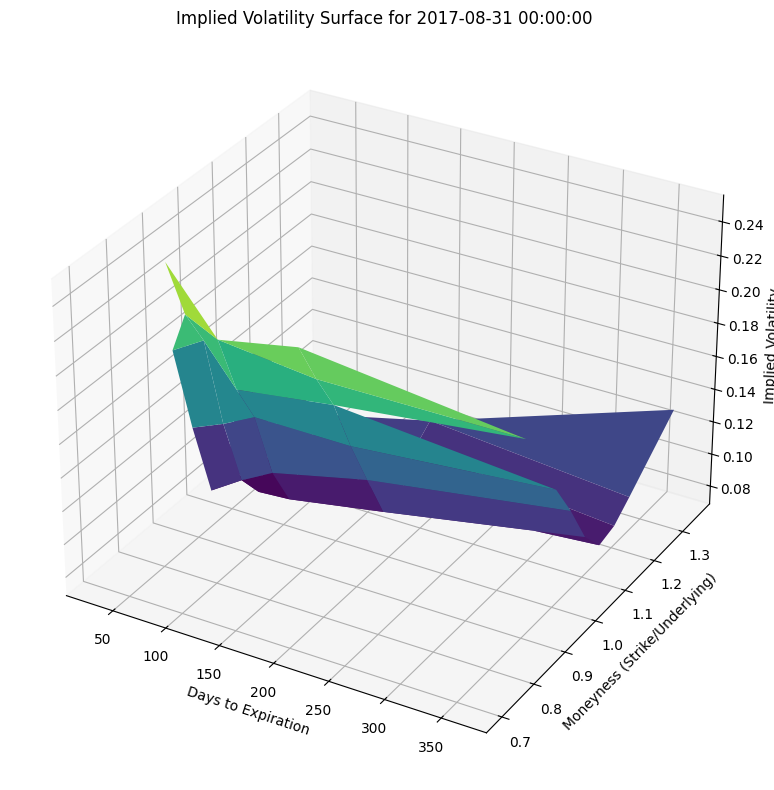

In [ ]:
def plot_vol_surface(date_str):
    date = pd.to_datetime(date_str)
    day_data = calls[calls['date'] == date]

    if len(day_data) == 0:
        print(f"No call options data for {date_str}")
        return

    pivot = day_data.pivot_table(
        values='impl_volatility',
        index='moneyness_bucket',
        columns='expiry_bucket',
        aggfunc='mean'
    )

    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    x, y = np.meshgrid(pivot.columns, pivot.index)
    ax.plot_surface(x, y, pivot.values, cmap='viridis')

    ax.set_xlabel('Days to Expiration')
    ax.set_ylabel('Moneyness (Strike/Underlying)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(f'Implied Volatility Surface for {date_str}')

    plt.tight_layout()
    plt.show()

if len(complete_surfaces) > 0:
    sample_date = complete_surfaces[0]
    plot_vol_surface(sample_date)

In [ ]:
# Function to create a standardized volatility surface
def create_vol_surface(date, call_data, moneyness_levels, expiry_buckets):

    day_data = call_data[call_data['date'] == date]


    surface = np.zeros((len(moneyness_levels), len(expiry_buckets)))
    surface.fill(np.nan)

    for i, m in enumerate(moneyness_levels):
        for j, e in enumerate(expiry_buckets):
            subset = day_data[(day_data['moneyness_bucket'] == m) &
                              (day_data['expiry_bucket'] == e)]
            if not subset.empty:
                surface[i, j] = subset['impl_volatility'].mean()

    from scipy import interpolate

    for j in range(surface.shape[1]):
        col = surface[:, j]
        mask = ~np.isnan(col)
        if np.sum(mask) > 1:
            indices = np.arange(surface.shape[0])
            interp_func = interpolate.interp1d(
                indices[mask], col[mask],
                bounds_error=False, fill_value="extrapolate"
            )
            surface[:, j] = interp_func(indices)

    for i in range(surface.shape[0]):
        row = surface[i, :]
        mask = ~np.isnan(row)
        if np.sum(mask) > 1:
            indices = np.arange(surface.shape[1])
            interp_func = interpolate.interp1d(
                indices[mask], row[mask],
                bounds_error=False, fill_value="extrapolate"
            )
            surface[i, :] = interp_func(indices)

    global_mean = np.nanmean(surface)
    surface[np.isnan(surface)] = global_mean

    return surface

standard_moneyness = sorted(data['moneyness_bucket'].unique())
standard_expiry = sorted(data['expiry_bucket'].unique())

print(f"Standard moneyness levels: {standard_moneyness}")
print(f"Standard expiry buckets: {standard_expiry}")

filtered_dates = complete_surfaces

vol_surfaces = {}
for date in filtered_dates:
    vol_surfaces[date] = create_vol_surface(
        date, calls, standard_moneyness, standard_expiry
    )

print(f"Created {len(vol_surfaces)} volatility surfaces")

Standard moneyness levels: [np.float64(0.7), np.float64(0.75), np.float64(0.8), np.float64(0.8500000000000001), np.float64(0.9000000000000001), np.float64(0.9500000000000002), np.float64(1.0000000000000002), np.float64(1.0500000000000003), np.float64(1.1000000000000003), np.float64(1.1500000000000004), np.float64(1.2000000000000004), np.float64(1.2500000000000004), np.float64(1.3000000000000005), np.float64(1.3500000000000005)]
Standard expiry buckets: [np.int64(30), np.int64(60), np.int64(90), np.int64(180), np.int64(365)]
Created 1510 volatility surfaces


In [ ]:
# Create sequences for LSTM
def create_sequences(surfaces, dates, lookback=20):
    """
    Create sequences of volatility surfaces for LSTM
    X: sequence of volatility surfaces
    y: next day's volatility surface (or chosen target)
    """
    X, y = [], []
    dates = sorted(dates)

    for i in range(lookback, len(dates)):

        seq = []
        for j in range(i - lookback, i):
            seq.append(surfaces[dates[j]])


        target = surfaces[dates[i]]

        X.append(np.array(seq))
        y.append(target)

    return np.array(X), np.array(y)

date_list = sorted(filtered_dates)

# Create sequences with 20-day lookback
lookback = 20
X, y = create_sequences(vol_surfaces, date_list, lookback)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1490, 20, 14, 5)
y shape: (1490, 14, 5)


In [ ]:
# Split data chronologically
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Reshape for LSTM input
n_samples, time_steps, n_moneyness, n_expiry = X_train.shape
X_train_reshaped = X_train.reshape(n_samples, time_steps, n_moneyness * n_expiry)
X_val_reshaped = X_val.reshape(X_val.shape[0], time_steps, n_moneyness * n_expiry)
X_test_reshaped = X_test.reshape(X_test.shape[0], time_steps, n_moneyness * n_expiry)

# Similarly reshape targets
y_train_reshaped = y_train.reshape(y_train.shape[0], n_moneyness * n_expiry)
y_val_reshaped = y_val.reshape(y_val.shape[0], n_moneyness * n_expiry)
y_test_reshaped = y_test.reshape(y_test.shape[0], n_moneyness * n_expiry)

Training set: 1043 samples
Validation set: 223 samples
Test set: 224 samples


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │       101,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 70)             │         4,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,614 (611.77 KB)

 Trainable params: 156,230 (610.27 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.9697

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.9545 - val_loss: 0.0893 - learning_rate: 0.0010
Epoch 2/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4060

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.4045 - val_loss: 0.0686 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3256

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.3251 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 4/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2584

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.2578 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2123

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2120 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 6/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1778

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.1774 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1468

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1466 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 8/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1252

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1249 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 9/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1043

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1041 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0886

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0885 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0744

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0743 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0628 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 13/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0545

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0544 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0447 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0393 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0333

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0332 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 17/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0290

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0290 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0243

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0243 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0219

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0218 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0184

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0184 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 21/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0159 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 22/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0144 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0122 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 24/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0111 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0096 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 26/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0090 - val_loss: 0.0117 - learning_rate: 5.0000e-04
Epoch 27/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0094 - val_loss: 0.0117 - learning_rate: 5.0000e-04
Epoch 28/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0081 - val_loss: 0.0117 - learning_rate: 5.0000e-04
Epoch 29/5

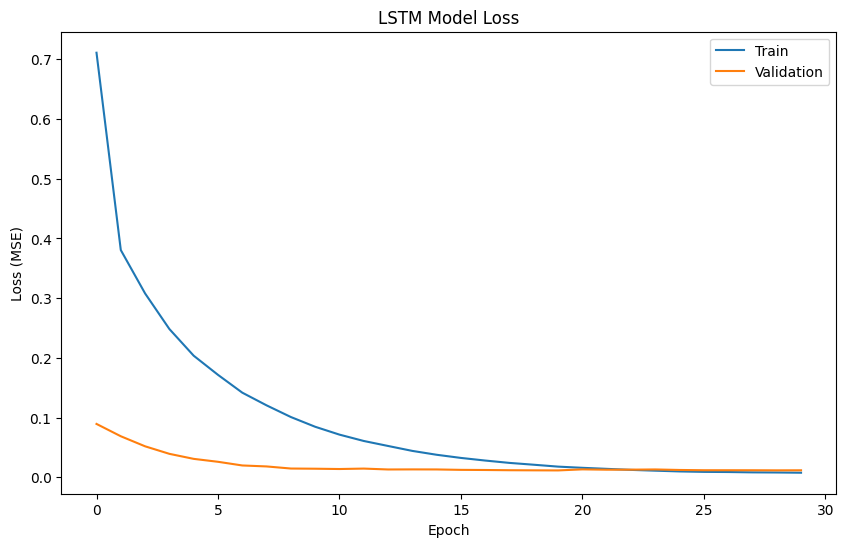

In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True,
         input_shape=(time_steps, n_moneyness * n_expiry)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),
    Dense(n_moneyness * n_expiry)
])

# Compile model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Set up callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_vol_lstm.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001)
]

# Train model
history = model.fit(
    X_train_reshaped, y_train_reshaped,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_reshaped),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 128)        │       101,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │         4,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,206 (918.77 KB)

 Trainable params: 234,630 (916.52 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.9247

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.9112 - val_loss: 0.0892 - learning_rate: 0.0010
Epoch 2/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3970

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.3952 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 3/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.3045

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.3036 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 4/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2490

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.2482 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 5/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2037

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.2031 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.1635

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.1633 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 7/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1352

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.1349 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 8/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1145

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1142 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 9/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0978

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0975 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0785

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0784 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0663

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0662 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 12/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0561

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0560 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 13/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0470

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0469 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 14/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0406

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0405 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0341 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0292 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 17/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0253

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0253 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0216 - val_loss: 0.0108 - learning_rate: 0.0010
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0184 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0155 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 21/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0138 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 22/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0127 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0107 - val_loss: 0.0111 - learning_rate: 5.0000e-04
Epoch 24/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0106 - val_loss: 0.0111 - learning_rate: 5.0000e-04
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0095 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 26/

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0098 - val_loss: 0.0106 - learning_rate: 5.0000e-04
Epoch 27/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0095 - val_loss: 0.0112 - learning_rate: 5.0000e-04
Epoch 28/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0079 - val_loss: 0.0107 - learning_rate: 5.0000e-04
Epoch 29/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0080 - val_loss: 0.0112 - learning_rate: 5.0000e-04
Epoch 30/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0078 - val_loss: 0.0110 - learning_rate: 5.0000e-04
Epoch 31/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0078 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 32/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0066 - val_loss: 0.0109 - learning_rate: 2.5000e-04
Epoch 33/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0070 - val_loss: 0.0107 - learning_rate: 2.5000e-04
Epoch 34/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0068 - val_loss: 0.0106 - learning_ra

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0063 - val_loss: 0.0106 - learning_rate: 2.5000e-04
Epoch 36/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0070 - val_loss: 0.0106 - learning_rate: 2.5000e-04
Epoch 37/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0062 - val_loss: 0.0106 - learning_rate: 1.2500e-04
Epoch 38/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0067

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0067 - val_loss: 0.0104 - learning_rate: 1.2500e-04
Epoch 39/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0066

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0065 - val_loss: 0.0104 - learning_rate: 1.2500e-04
Epoch 40/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0063

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0063 - val_loss: 0.0104 - learning_rate: 1.2500e-04
Epoch 41/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.0063 - val_loss: 0.0104 - learning_rate: 1.2500e-04
Epoch 42/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0059 - val_loss: 0.0105 - learning_rate: 1.2500e-04
Epoch 43/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0064 - val_loss: 0.0104 - learning_rate: 1.2500e-04
Epoch 44/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0064 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 45/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0067 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 46/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0062 - val_loss: 0.0105 - learning_rate: 1.0000e-04
Epoch 47/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0062 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 48/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0062 - val_loss: 0.0104 - learning_r

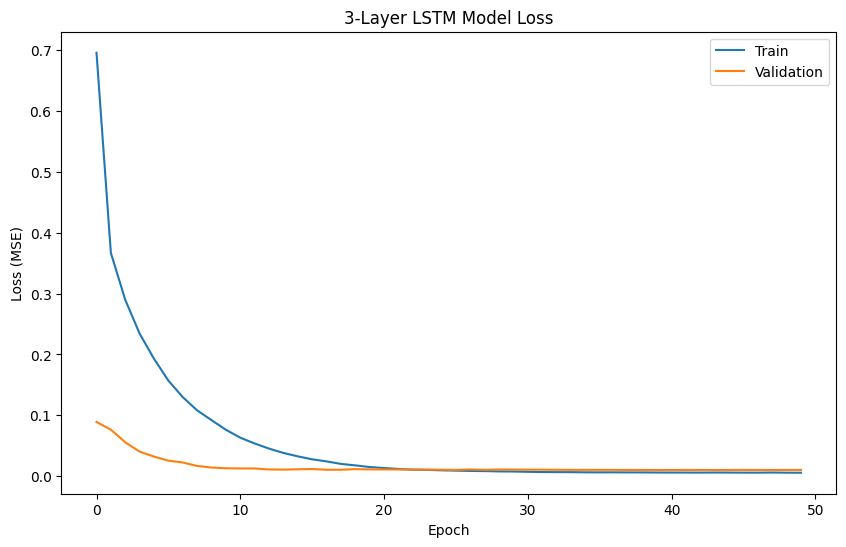

In [ ]:
# Build 3-Layer LSTM model
medium_model = Sequential([
    # First LSTM layer
    LSTM(128, return_sequences=True,
         input_shape=(time_steps, n_moneyness * n_expiry)),
    BatchNormalization(),
    Dropout(0.3),

    # Second LSTM layer
    LSTM(96, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Third and final LSTM layer
    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer
    Dense(n_moneyness * n_expiry)
])

# Compile model
medium_model.compile(optimizer='adam', loss='mse')
medium_model.summary()

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set up callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_medium_lstm.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001)
]

# Train model
medium_history = medium_model.fit(
    X_train_reshaped, y_train_reshaped,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_reshaped),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(medium_history.history['loss'])
plt.plot(medium_history.history['val_loss'])
plt.title('3-Layer LSTM Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 20, 128)        │       101,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 20, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 20, 96)         │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 20, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 70)             │         4,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,302 (1.40 MB)

 Trainable params: 366,470 (1.40 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.9864

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - loss: 0.9793 - val_loss: 0.0840 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.4111

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.4102 - val_loss: 0.0707 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.3043

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.3039 - val_loss: 0.0583 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2441

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.2438 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.2045

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.2042 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1649

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.1647 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1377

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.1375 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1148

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.1147 - val_loss: 0.0169 - learning_rate: 0.0010
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0958

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0956 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0787

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0786 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0658 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0547 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0465

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0465 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 0.0391 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0330

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - loss: 0.0330 - val_loss: 0.0126 - learning_rate: 0.0010
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0283

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0283 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 17/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0243

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.0242 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0210

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0210 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - loss: 0.0174 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0156 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 21/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0137 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 22/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0116 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 23/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0103 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 24/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0097 - val_loss: 0.0117 - learning_rate: 5.0000e-04
Epoch 25/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.0089 - val_loss: 0.0111 - learning_rate: 5.0000e-04
Epoch 26/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0084 - val_loss: 0.0112 - learning_rate: 5.0000e-04
Ep

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0074 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 29/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0075 - val_loss: 0.0112 - learning_rate: 5.0000e-04
Epoch 30/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - loss: 0.0070 - val_loss: 0.0111 - learning_rate: 5.0000e-04
Epoch 31/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0065 - val_loss: 0.0113 - learning_rate: 5.0000e-04
Epoch 32/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0064 - val_loss: 0.0110 - learning_rate: 5.0000e-04
Epoch 33/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0065 - val_loss: 0.0109 - learning_rate: 5.0000e-04
Epoch 34/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0069 - val_loss: 0.0110 - learning_rate: 2.5000e-04
Epoch 35/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0069 - val_loss: 0.0108 - learning_rate: 2.5000e-04
Epoch 36/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0062

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.0062 - val_loss: 0.0107 - learning_rate: 2.5000e-04
Epoch 37/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0064 - val_loss: 0.0110 - learning_rate: 2.5000e-04
Epoch 38/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0057

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0057 - val_loss: 0.0107 - learning_rate: 2.5000e-04
Epoch 39/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0053 - val_loss: 0.0107 - learning_rate: 1.2500e-04
Epoch 40/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0054 - val_loss: 0.0108 - learning_rate: 1.2500e-04
Epoch 41/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0058 - val_loss: 0.0108 - learning_rate: 1.2500e-04
Epoch 42/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0050 - val_loss: 0.0107 - learning_rate: 1.2500e-04
Epoch 43/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0057

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0057 - val_loss: 0.0106 - learning_rate: 1.2500e-04
Epoch 44/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.0056 - val_loss: 0.0107 - learning_rate: 1.2500e-04
Epoch 45/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0052 - val_loss: 0.0107 - learning_rate: 1.2500e-04
Epoch 46/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0055 - val_loss: 0.0107 - learning_rate: 1.2500e-04
Epoch 47/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0052 - val_loss: 0.0107 - learning_rate: 1.2500e-04
Epoch 48/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0051 - val_loss: 0.0107 - learning_rate: 1.2500e-04
Epoch 49/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.0055 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 50/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0052 - val_loss: 0.0107 - learning_rate: 1.0000e-04


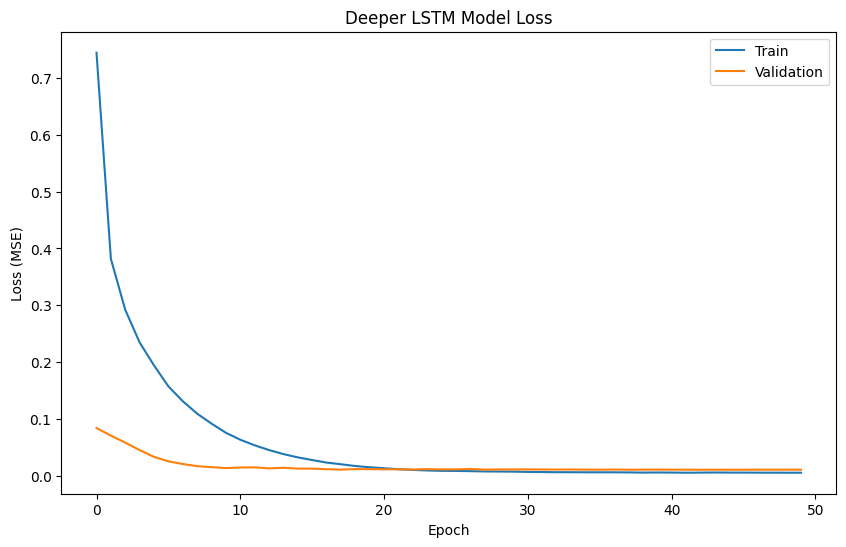

In [ ]:
# Build Deeper LSTM model
deeper_model = Sequential([
    # First LSTM layer
    LSTM(128, return_sequences=True,
         input_shape=(time_steps, n_moneyness * n_expiry)),
    BatchNormalization(),
    Dropout(0.3),

    # Second LSTM layer
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Third LSTM layer
    LSTM(96, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    # Fourth and final LSTM layer
    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer
    Dense(n_moneyness * n_expiry)
])

# Compile model
deeper_model.compile(optimizer='adam', loss='mse')
deeper_model.summary()

# Set up callback
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_deeper_lstm.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001)
]

# Train model
deeper_history = deeper_model.fit(
    X_train_reshaped, y_train_reshaped,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_reshaped),
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(deeper_history.history['loss'])
plt.plot(deeper_history.history['val_loss'])
plt.title('Deeper LSTM Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_models(models, model_names, X_test, y_test, moneyness_levels, expiry_buckets):

    results = {name: {} for name in model_names}

    if len(y_test.shape) == 2:
        n_samples = y_test.shape[0]
        n_moneyness = len(moneyness_levels)
        n_expiry = len(expiry_buckets)
        y_test_surfaces = y_test.reshape(n_samples, n_moneyness, n_expiry)
    else:
        y_test_surfaces = y_test
        n_samples, n_moneyness, n_expiry = y_test_surfaces.shape

    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()
    short_exp_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

    all_predictions = []

    for i, (model, name) in enumerate(zip(models, model_names)):
        print(f"\nEvaluating {name}...")

        start_time = time.time()
        predictions = model.predict(X_test)
        end_time = time.time()
        inference_time = (end_time - start_time) / len(X_test)

        if len(predictions.shape) == 2:
            pred_surfaces = predictions.reshape(n_samples, n_moneyness, n_expiry)
        else:
            pred_surfaces = predictions

        all_predictions.append(pred_surfaces)

        mse = mean_squared_error(y_test.flatten(), predictions.flatten())
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

        atm_short_true = y_test_surfaces[:, atm_idx, short_exp_idx]
        atm_short_pred = pred_surfaces[:, atm_idx, short_exp_idx]
        atm_mse = mean_squared_error(atm_short_true, atm_short_pred)
        atm_rmse = np.sqrt(atm_mse)

        directional_correct = 0
        for j in range(1, len(atm_short_true)):
            actual_change = atm_short_true[j] - atm_short_true[j-1]
            pred_change = atm_short_pred[j] - atm_short_true[j-1]
            if (actual_change * pred_change) > 0:  # Same direction
                directional_correct += 1

        directional_accuracy = directional_correct / (len(atm_short_true) - 1)

        # Store results
        results[name] = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'atm_rmse': atm_rmse,
            'directional_accuracy': directional_accuracy,
            'inference_time': inference_time,
            'predictions': pred_surfaces
        }

        # Print metrics
        print(f"  MSE: {mse:.6f}")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  MAE: {mae:.6f}")
        print(f"  ATM Short-Term RMSE: {atm_rmse:.6f}")
        print(f"  Directional Accuracy: {directional_accuracy*100:.2f}%")
        print(f"  Inference Time: {inference_time*1000:.2f} ms per sample")

    # Visualize comparison
    visualize_model_comparison(results, model_names, y_test_surfaces, moneyness_levels, expiry_buckets)

    return results

def visualize_model_comparison(results, model_names, y_test_surfaces, moneyness_levels, expiry_buckets):

    plt.figure(figsize=(20, 15))

    plt.subplot(2, 2, 1)
    metrics = ['RMSE', 'MAE', 'ATM RMSE']
    x = np.arange(len(metrics))
    width = 0.8 / len(model_names)
    offsets = np.linspace(-(len(model_names)-1)*width/2, (len(model_names)-1)*width/2, len(model_names))

    for i, name in enumerate(model_names):
        values = [results[name]['rmse'], results[name]['mae'], results[name]['atm_rmse']]
        plt.bar(x + offsets[i], values, width, label=name)

    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Prediction Error Metrics')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, axis='y')

    plt.subplot(2, 2, 2)
    accuracies = [results[name]['directional_accuracy']*100 for name in model_names]

    plt.bar(model_names, accuracies)
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.title('Directional Accuracy')
    plt.ylim(0, 100)
    plt.grid(True, axis='y')

    plt.subplot(2, 2, 3)
    times = [results[name]['inference_time']*1000 for name in model_names]

    plt.bar(model_names, times)
    plt.xlabel('Model')
    plt.ylabel('Time (ms)')
    plt.title('Inference Time per Sample')
    plt.grid(True, axis='y')

    plt.subplot(2, 2, 4)
    param_counts = [model.count_params() for model in models]

    plt.bar(model_names, param_counts)
    plt.xlabel('Model')
    plt.ylabel('Number of Parameters')
    plt.title('Model Size')
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.show()

    visualize_sample_predictions(results, model_names, y_test_surfaces, moneyness_levels, expiry_buckets)

def visualize_sample_predictions(results, model_names, y_test_surfaces, moneyness_levels, expiry_buckets):

    sample_idx = len(y_test_surfaces) // 2

    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()
    short_exp_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

    plt.figure(figsize=(20, 15))

    plt.subplot(2, 2, 1)

    # Actual values
    plt.plot(expiry_buckets, y_test_surfaces[sample_idx, atm_idx, :], 'k-', linewidth=2, label='Actual')

    # Predicted values
    for name in model_names:
        predictions = results[name]['predictions']
        plt.plot(expiry_buckets, predictions[sample_idx, atm_idx, :], '--', label=f'{name} Prediction')

    plt.xlabel('Days to Expiration')
    plt.ylabel('Implied Volatility')
    plt.title('ATM Volatility Term Structure (Sample Date)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)

    # Actual values
    plt.plot(moneyness_levels, y_test_surfaces[sample_idx, :, short_exp_idx], 'k-', linewidth=2, label='Actual')

    # Predicted values
    for name in model_names:
        predictions = results[name]['predictions']
        plt.plot(moneyness_levels, predictions[sample_idx, :, short_exp_idx], '--', label=f'{name} Prediction')

    plt.xlabel('Moneyness')
    plt.ylabel('Implied Volatility')
    plt.title(f'Volatility Smile at {expiry_buckets[short_exp_idx]}-Day Expiry (Sample Date)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)

    n_dates = min(50, len(y_test_surfaces))
    date_indices = np.linspace(0, len(y_test_surfaces)-1, n_dates, dtype=int)

    # Actual values
    actual_atm_series = y_test_surfaces[date_indices, atm_idx, short_exp_idx]
    plt.plot(range(len(date_indices)), actual_atm_series, 'k-', linewidth=2, label='Actual')

    # Predicted values
    for name in model_names:
        predictions = results[name]['predictions']
        pred_atm_series = predictions[date_indices, atm_idx, short_exp_idx]
        plt.plot(range(len(date_indices)), pred_atm_series, '--', label=f'{name} Prediction')

    plt.xlabel('Sample Date Index')
    plt.ylabel('Implied Volatility')
    plt.title(f'ATM {expiry_buckets[short_exp_idx]}-Day Implied Volatility Time Series')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)

    name = model_names[0]
    predictions = results[name]['predictions']

    abs_errors = np.abs(y_test_surfaces[sample_idx] - predictions[sample_idx])

    #  heatmap
    im = plt.imshow(abs_errors, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Absolute Error')
    plt.xlabel('Expiry Bucket Index')
    plt.ylabel('Moneyness Level Index')
    plt.title(f'Prediction Error Heatmap - {name} (Sample Date)')

    plt.xticks(range(len(expiry_buckets)), expiry_buckets, rotation=45)
    plt.yticks(range(len(moneyness_levels)), moneyness_levels)

    plt.tight_layout()
    plt.show()

    plot_regional_errors(results, model_names, y_test_surfaces, moneyness_levels, expiry_buckets)

def plot_regional_errors(results, model_names, y_test_surfaces, moneyness_levels, expiry_buckets):

    regions = [
        {'name': 'ATM Short-Term',
         'm_range': (np.abs(np.array(moneyness_levels) - 1.0) < 0.05),
         'e_range': (np.array(expiry_buckets) <= 30)},
        {'name': 'OTM Puts Short-Term',
         'm_range': (np.array(moneyness_levels) < 0.9),
         'e_range': (np.array(expiry_buckets) <= 30)},
        {'name': 'OTM Calls Short-Term',
         'm_range': (np.array(moneyness_levels) > 1.1),
         'e_range': (np.array(expiry_buckets) <= 30)},
        {'name': 'ATM Long-Term',
         'm_range': (np.abs(np.array(moneyness_levels) - 1.0) < 0.05),
         'e_range': (np.array(expiry_buckets) > 90)}
    ]

    region_errors = {name: [] for name in model_names}

    for region in regions:
        m_mask = region['m_range']
        e_mask = region['e_range']

        for name in model_names:
            predictions = results[name]['predictions']

            mse_sum = 0
            count = 0

            for m_idx in range(len(moneyness_levels)):
                if not m_mask[m_idx]:
                    continue

                for e_idx in range(len(expiry_buckets)):
                    if not e_mask[e_idx]:
                        continue

                    actual = y_test_surfaces[:, m_idx, e_idx]
                    pred = predictions[:, m_idx, e_idx]

                    # Calculate MSE
                    mse = np.mean((actual - pred) ** 2)
                    mse_sum += mse
                    count += 1

            # Average MSE across region
            avg_mse = mse_sum / count if count > 0 else 0
            rmse = np.sqrt(avg_mse)

            region_errors[name].append(rmse)

    plt.figure(figsize=(12, 8))

    x = np.arange(len(regions))
    width = 0.8 / len(model_names)
    offsets = np.linspace(-(len(model_names)-1)*width/2, (len(model_names)-1)*width/2, len(model_names))

    for i, name in enumerate(model_names):
        plt.bar(x + offsets[i], region_errors[name], width, label=name)

    plt.xlabel('Volatility Surface Region')
    plt.ylabel('RMSE')
    plt.title('Prediction Error by Volatility Surface Region')
    plt.xticks(x, [region['name'] for region in regions])
    plt.legend()
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nRegional Performance Summary:")
    print("-" * 50)

    for i, region in enumerate(regions):
        print(f"\n{region['name']}:")
        for name in model_names:
            print(f"  {name}: RMSE = {region_errors[name][i]:.6f}")


Evaluating 2-Layer LSTM...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
  MSE: 0.009598
  RMSE: 0.097968
  MAE: 0.039099
  ATM Short-Term RMSE: 0.037862
  Directional Accuracy: 60.99%
  Inference Time: 6.09 ms per sample

Evaluating 3-Layer LSTM...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
  MSE: 0.009475
  RMSE: 0.097338
  MAE: 0.036779
  ATM Short-Term RMSE: 0.032902
  Directional Accuracy: 55.61%
  Inference Time: 6.00 ms per sample

Evaluating 4-Layer LSTM...
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
  MSE: 0.009397
  RMSE: 0.096938
  MAE: 0.037215
  ATM Short-Term RMSE: 0.033409
  Directional Accuracy: 52.47%
  Inference Time: 5.89 ms per sample


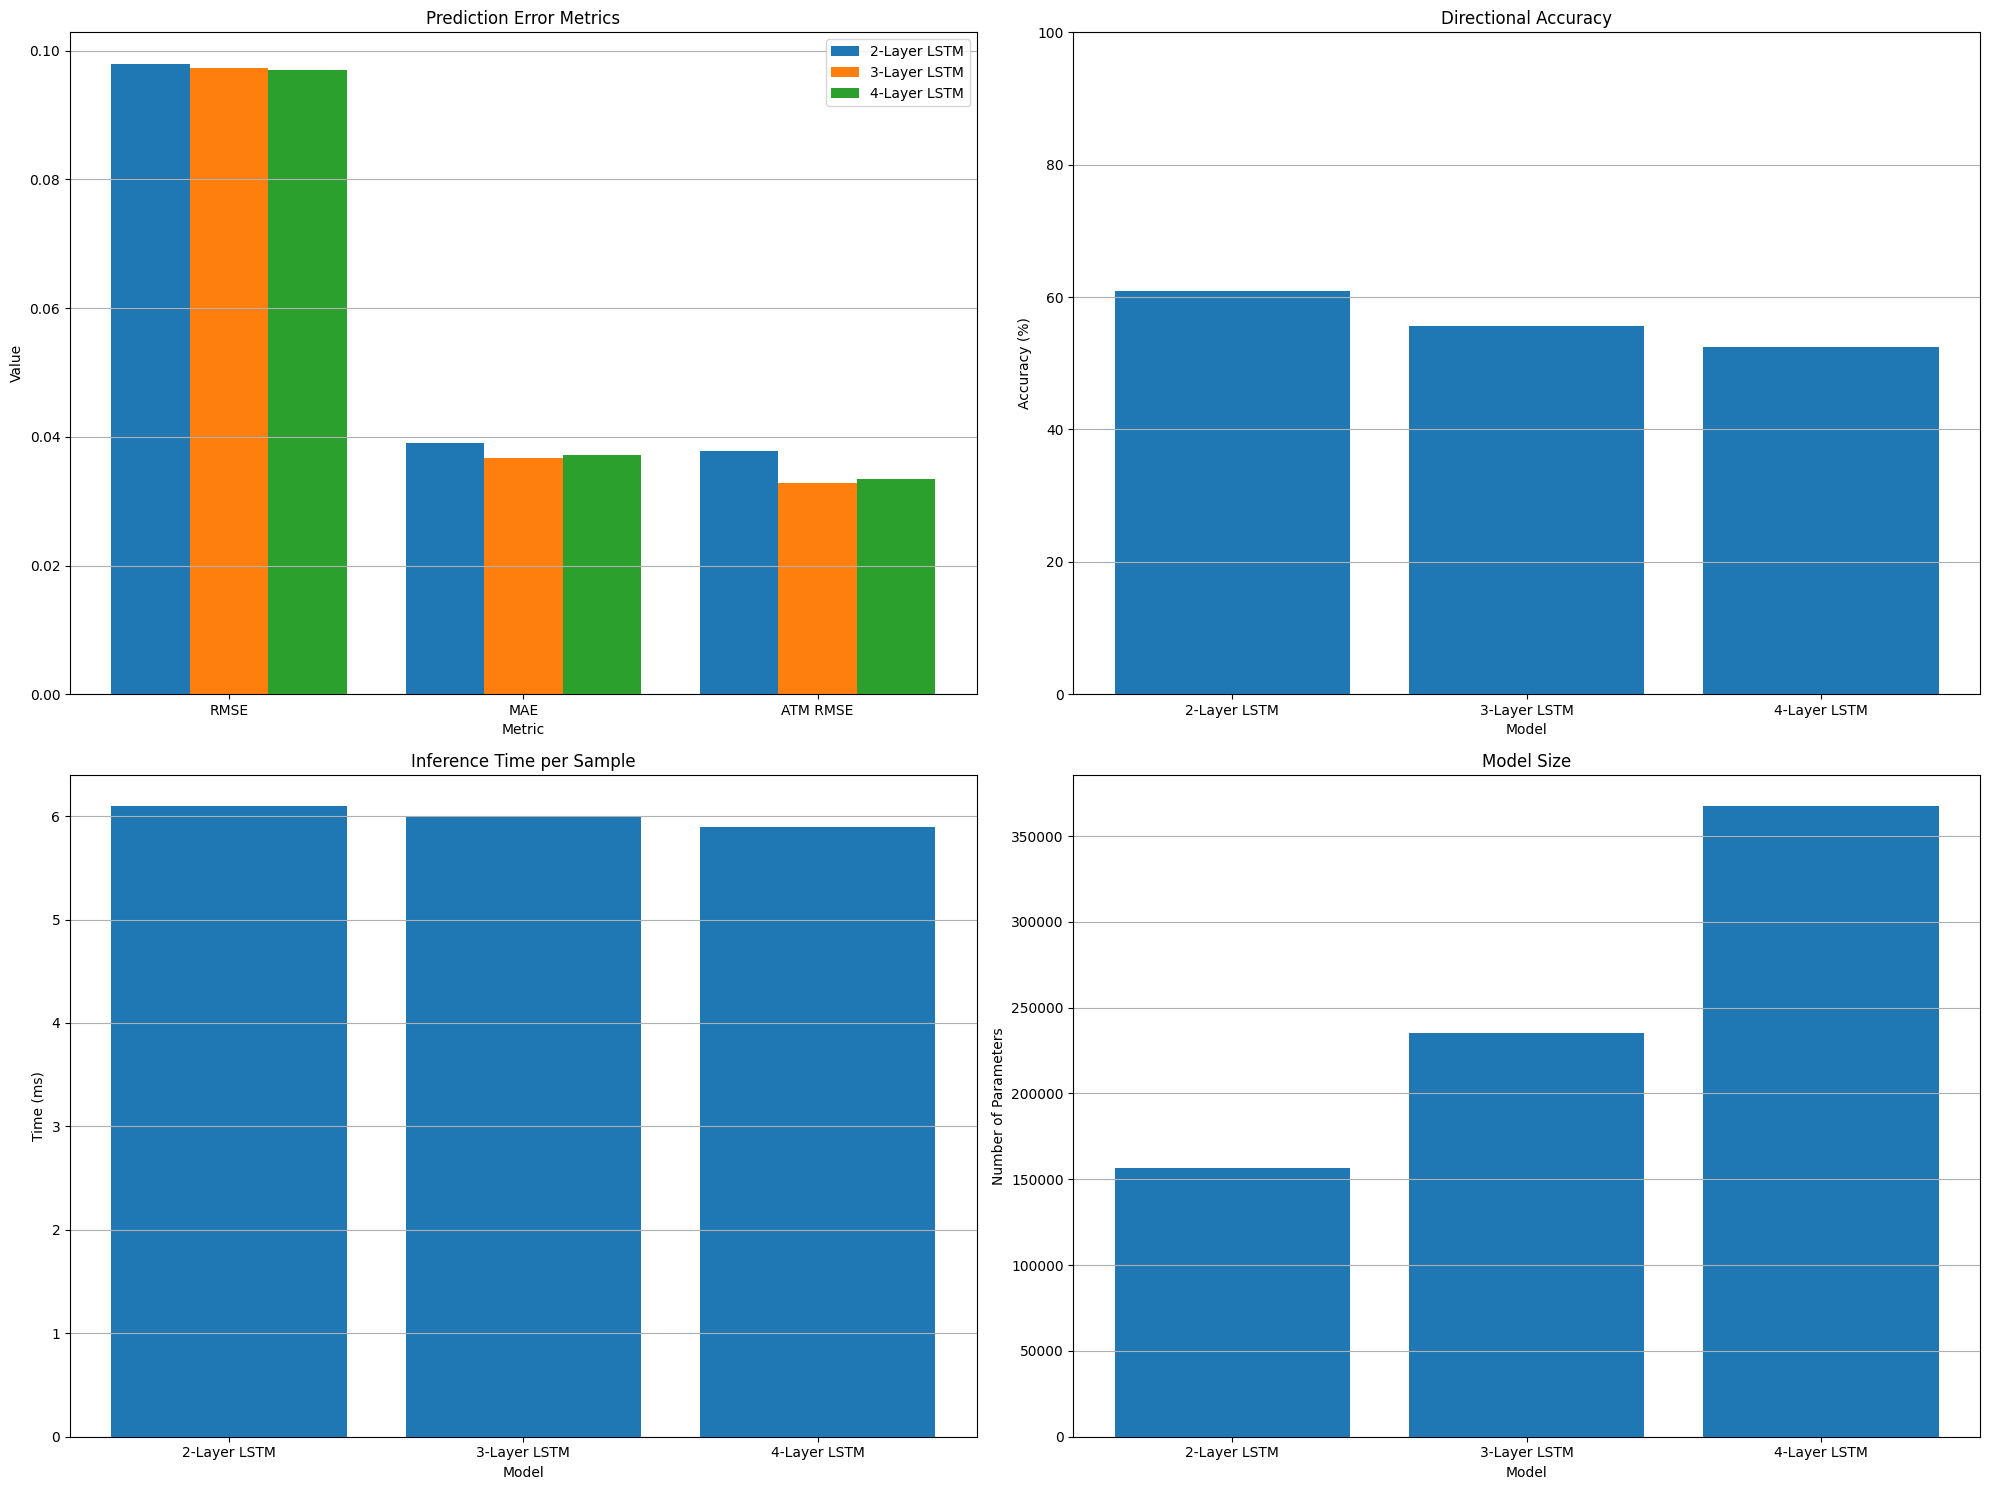

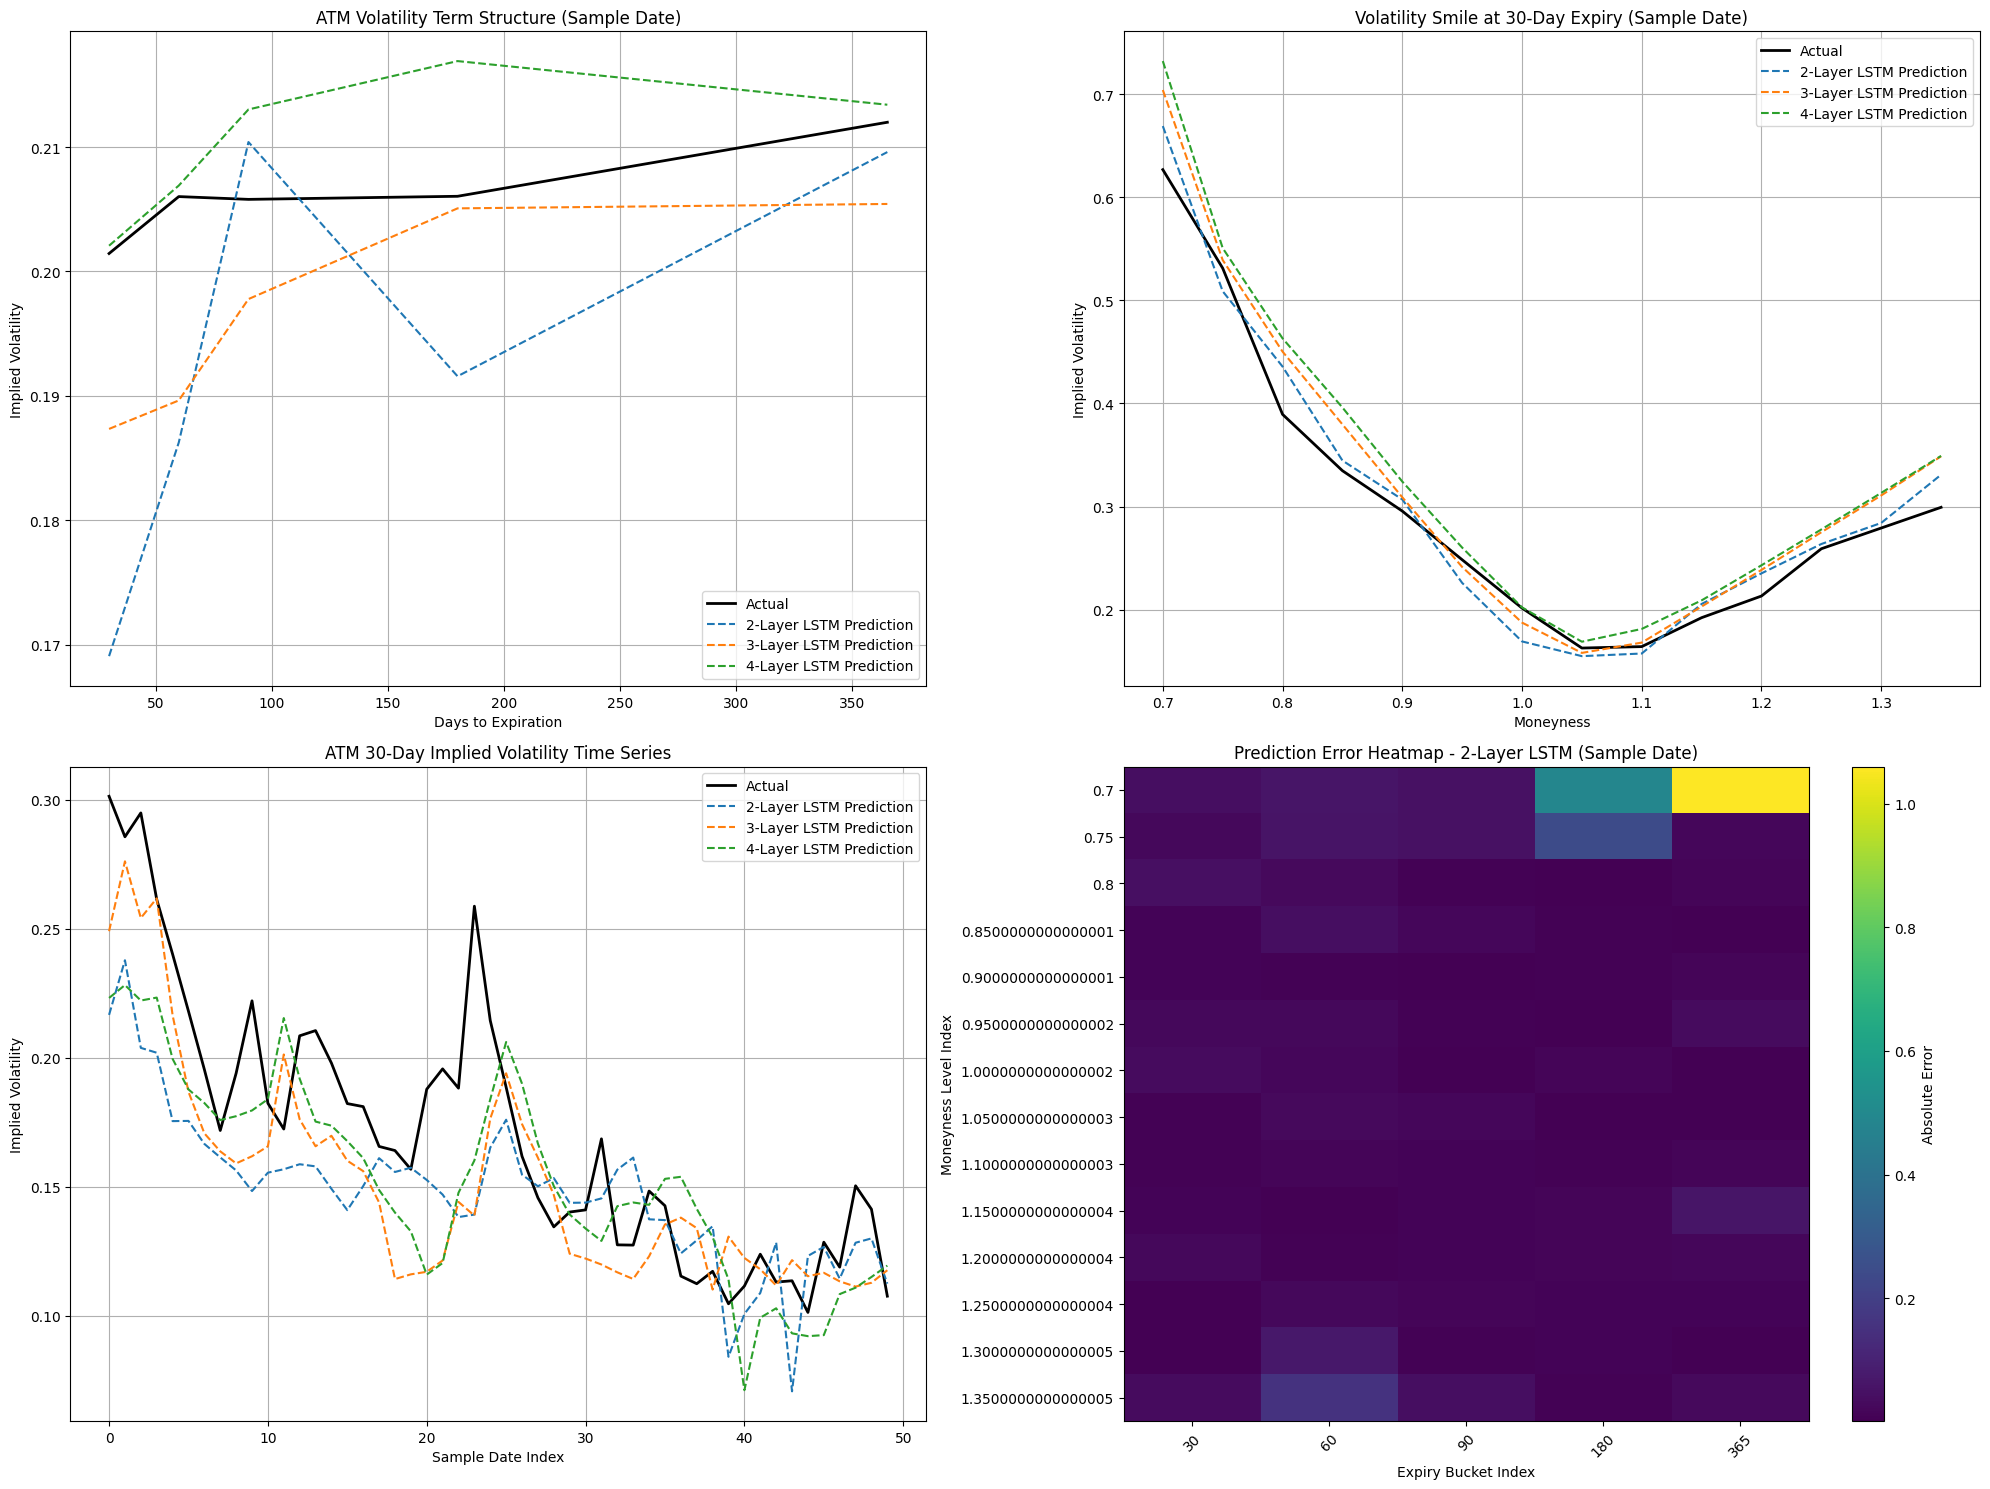

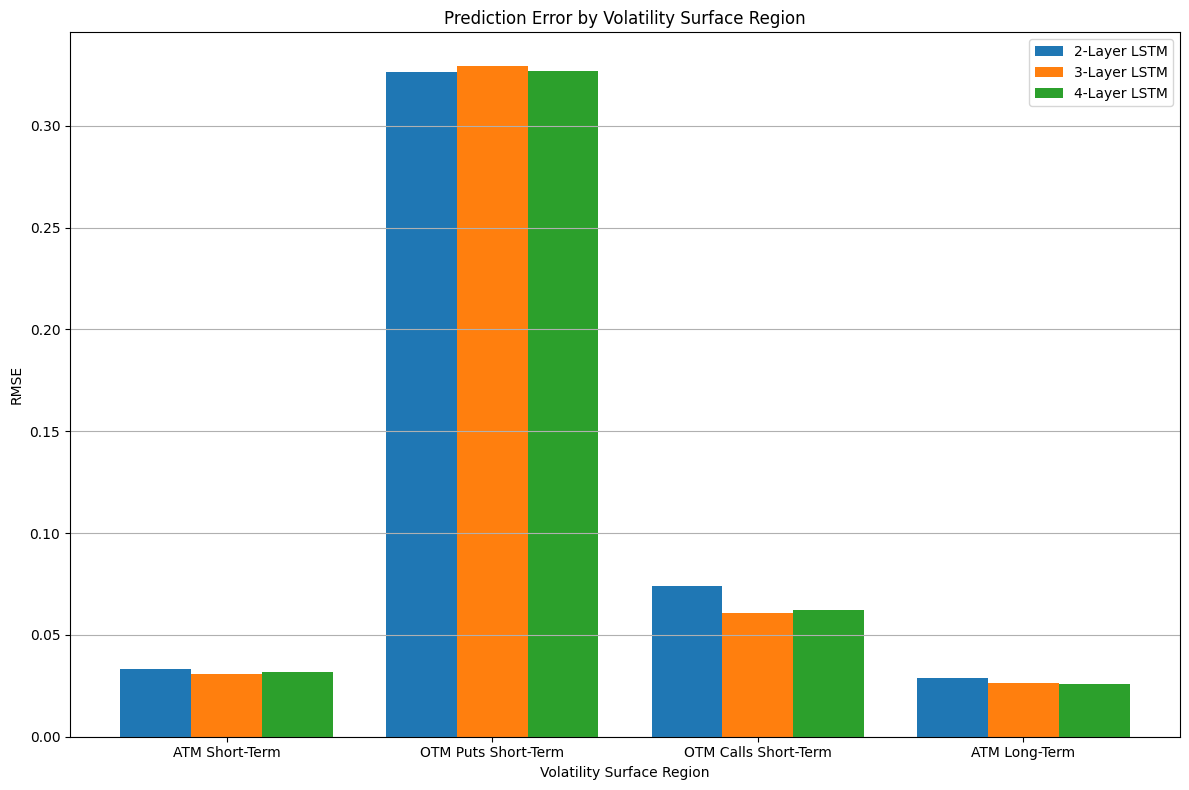


Regional Performance Summary:
--------------------------------------------------

ATM Short-Term:
  2-Layer LSTM: RMSE = 0.033213
  3-Layer LSTM: RMSE = 0.030702
  4-Layer LSTM: RMSE = 0.031593

OTM Puts Short-Term:
  2-Layer LSTM: RMSE = 0.326557
  3-Layer LSTM: RMSE = 0.329407
  4-Layer LSTM: RMSE = 0.327069

OTM Calls Short-Term:
  2-Layer LSTM: RMSE = 0.073799
  3-Layer LSTM: RMSE = 0.060512
  4-Layer LSTM: RMSE = 0.062180

ATM Long-Term:
  2-Layer LSTM: RMSE = 0.029031
  3-Layer LSTM: RMSE = 0.026134
  4-Layer LSTM: RMSE = 0.025664


In [ ]:
models = [model, medium_model, deeper_model]
model_names = ["2-Layer LSTM", "3-Layer LSTM", "4-Layer LSTM"]

moneyness_levels = sorted(data['moneyness_bucket'].unique())
expiry_buckets = sorted(data['expiry_bucket'].unique())

# Run evaluation
evaluation_results = evaluate_models(
    models=models,
    model_names=model_names,
    X_test=X_test_reshaped,
    y_test=y_test_reshaped,
    moneyness_levels=moneyness_levels,
    expiry_buckets=expiry_buckets
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time

In [ ]:
def generate_trading_signals(actual_surfaces, predicted_surfaces, dates,
                            moneyness_levels, expiry_buckets):

    signals = {}

    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()

    short_exp_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

    for i, date in enumerate(dates):
        if i >= len(actual_surfaces) or i >= len(predicted_surfaces):
            continue

        actual = actual_surfaces[i]
        predicted = predicted_surfaces[i]

        actual_vol = actual[atm_idx, short_exp_idx]
        predicted_vol = predicted[atm_idx, short_exp_idx]

        vol_signal = predicted_vol - actual_vol

        signals[date] = vol_signal

    return signals

def determine_trades(signals, threshold=0.01):

    trades = {}

    for date, signal in signals.items():
        if signal > threshold:
            trades[date] = {
                'direction': 'LONG_VOL',
                'instrument': 'ATM_STRADDLE',
                'signal': signal
            }
        elif signal < -threshold:
            trades[date] = {
                'direction': 'SHORT_VOL',
                'instrument': 'ATM_STRADDLE',
                'signal': signal
            }
        else:
            trades[date] = {
                'direction': 'NO_TRADE',
                'instrument': None,
                'signal': signal
            }

    return trades

def apply_risk_management(trades, capital=100000, max_risk_per_trade=0.02):

    risk_managed_trades = {}

    for date, trade in trades.items():
        direction = trade['direction']
        signal = abs(trade['signal'])

        risk_fraction = min(signal * 2, max_risk_per_trade)
        position_size = capital * risk_fraction

        risk_managed_trades[date] = trade.copy()

        if direction != 'NO_TRADE':
            risk_managed_trades[date]['position_size'] = position_size
            risk_managed_trades[date]['risk_fraction'] = risk_fraction
        else:
            risk_managed_trades[date]['position_size'] = 0
            risk_managed_trades[date]['risk_fraction'] = 0

    return risk_managed_trades

def calculate_option_price(volatility, underlying_price, days_to_expiry,
                           is_call=True, moneyness=1.0):

    strike = underlying_price * moneyness
    time_in_years = max(days_to_expiry / 365, 0.01)
    vol = max(min(volatility, 2.0), 0.01)

    option_price = 0.4 * underlying_price * vol * np.sqrt(time_in_years)

    if is_call and moneyness < 1.0:  # ITM call
        option_price += (1.0 - moneyness) * underlying_price
    elif not is_call and moneyness > 1.0:  # ITM put
        option_price += (moneyness - 1.0) * underlying_price

    return max(option_price, 0.01)

def backtest_strategy(risk_managed_trades, actual_surfaces, dates,
                     moneyness_levels, expiry_buckets, underlying_prices):

    capital = 100000
    initial_capital = capital
    daily_returns = []
    equity_curve = [capital]
    positions = []
    trades_log = []

    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()
    exp_30_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

    open_positions = []

    for i in range(1, len(dates)):
        current_date = dates[i]
        prev_date = dates[i-1]

        current_price = underlying_prices[current_date]
        prev_price = underlying_prices[prev_date]
        current_vol = actual_surfaces[i][atm_idx, exp_30_idx]

        # Calculate P&L for existing positions
        day_pnl = 0
        closed_positions = []

        for j, position in enumerate(open_positions):
            entry_date, direction, entry_vol, position_size = position
            days_held = (dates.index(current_date) - dates.index(entry_date))

            # Hold positions for 5 days then close
            if days_held >= 5:
                # Calculate P&L for the position
                if direction == 'LONG_VOL':
                    vol_change = current_vol - entry_vol
                    pnl_pct = vol_change / entry_vol
                    position_pnl = position_size * pnl_pct
                else:  # 'SHORT_VOL'
                    # For short straddle, profit when vol decreases
                    vol_change = entry_vol - current_vol
                    pnl_pct = vol_change / entry_vol
                    position_pnl = position_size * pnl_pct

                day_pnl += position_pnl
                closed_positions.append(j)

                # Log the trade
                trades_log.append({
                    'entry_date': entry_date,
                    'exit_date': current_date,
                    'direction': direction,
                    'position_size': position_size,
                    'entry_vol': entry_vol,
                    'exit_vol': current_vol,
                    'pnl': position_pnl,
                    'pnl_pct': pnl_pct * 100
                })

        for j in sorted(closed_positions, reverse=True):
            open_positions.pop(j)

        if current_date in risk_managed_trades:
            trade = risk_managed_trades[current_date]

            if trade['direction'] != 'NO_TRADE':
                position_size = trade['position_size']
                open_positions.append([
                    current_date,
                    trade['direction'],
                    current_vol,
                    position_size
                ])

        capital += day_pnl

        daily_return = day_pnl / equity_curve[-1] if equity_curve[-1] > 0 else 0
        daily_returns.append(daily_return)

        equity_curve.append(capital)

        positions.append(len(open_positions))

    total_return = (capital / initial_capital - 1) * 100

    num_years = len(dates) / 252
    annualized_return = ((capital / initial_capital) ** (1/num_years) - 1) * 100

    daily_returns_arr = np.array(daily_returns)
    annualized_vol = np.std(daily_returns_arr) * np.sqrt(252) * 100

    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0

    running_max = np.maximum.accumulate(equity_curve)
    drawdowns = (running_max - equity_curve) / running_max * 100
    max_drawdown = np.max(drawdowns)

    winning_trades = sum(1 for trade in trades_log if trade['pnl'] > 0)
    win_rate = winning_trades / len(trades_log) if trades_log else 0

    results = {
        'equity_curve': equity_curve,
        'daily_returns': daily_returns,
        'trades': trades_log,
        'positions': positions,
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'num_trades': len(trades_log)
    }

    return results

In [ ]:
def options_trading_strategy(model, data, lookback=20, test_size=0.2, model_name="LSTM"):

    print(f"Implementing Options Trading Strategy for {model_name}")
    print("--------------------------------------")

    print("Creating volatility surfaces...")

    unique_dates = sorted(data['date'].unique())
    moneyness_levels = sorted(data['moneyness_bucket'].unique())
    expiry_buckets = sorted(data['expiry_bucket'].unique())

    calls = data[data['cp_flag'] == 'C'].copy()

    underlying_prices = {}
    for date, group in data.groupby('date'):
        underlying_prices[date] = group['underlying_price'].iloc[0]

    # Create volatility surfaces
    vol_surfaces = {}
    for date in unique_dates:
        day_data = calls[calls['date'] == date]


        surface = np.zeros((len(moneyness_levels), len(expiry_buckets)))
        surface.fill(np.nan)

        for i, m in enumerate(moneyness_levels):
            for j, e in enumerate(expiry_buckets):
                subset = day_data[(day_data['moneyness_bucket'] == m) &
                                 (day_data['expiry_bucket'] == e)]
                if not subset.empty:
                    surface[i, j] = subset['impl_volatility'].mean()


        for j in range(surface.shape[1]):
            col = surface[:, j]
            mask = ~np.isnan(col)
            if np.sum(mask) > 1:
                indices = np.arange(surface.shape[0])
                interp_func = interpolate.interp1d(
                    indices[mask], col[mask],
                    bounds_error=False, fill_value="extrapolate"
                )
                surface[:, j] = interp_func(indices)

        for i in range(surface.shape[0]):
            row = surface[i, :]
            mask = ~np.isnan(row)
            if np.sum(mask) > 1:
                indices = np.arange(surface.shape[1])
                interp_func = interpolate.interp1d(
                    indices[mask], row[mask],
                    bounds_error=False, fill_value="extrapolate"
                )
                surface[i, :] = interp_func(indices)

        mean_val = np.nanmean(surface)
        surface[np.isnan(surface)] = mean_val

        vol_surfaces[date] = surface

    print("Creating LSTM input sequences...")
    X, y = [], []
    dates = sorted(list(vol_surfaces.keys()))

    for i in range(lookback, len(dates)):
        # Input sequence
        seq = []
        for j in range(i - lookback, i):
            seq.append(vol_surfaces[dates[j]])

        target = vol_surfaces[dates[i]]

        X.append(np.array(seq))
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    sequence_dates = dates[lookback:]
    train_dates = sequence_dates[:train_size]
    test_dates = sequence_dates[train_size:]

    n_samples, time_steps, n_moneyness, n_expiry = X_test.shape
    X_test_reshaped = X_test.reshape(n_samples, time_steps, n_moneyness * n_expiry)

    print("Generating volatility surface predictions...")
    start_time = time.time()
    y_pred = model.predict(X_test_reshaped)
    prediction_time = time.time() - start_time
    print(f"Prediction completed in {prediction_time:.2f} seconds")

    y_pred_surfaces = y_pred.reshape(n_samples, n_moneyness, n_expiry)

    print("Generating trading signals...")
    signals = generate_trading_signals(y_test, y_pred_surfaces, test_dates,
                                      moneyness_levels, expiry_buckets)

    print("Determining option trades...")
    trades = determine_trades(signals)

    print("Applying risk management...")
    risk_managed_trades = apply_risk_management(trades)

    print("Running backtest...")
    backtest_results = backtest_strategy(risk_managed_trades, y_test, test_dates,
                                        moneyness_levels, expiry_buckets,
                                        underlying_prices)

    print("Visualizing results...")

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(backtest_results['equity_curve'])
    plt.title(f'Strategy Equity Curve - {model_name}')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.bar(range(len(backtest_results['positions'])), backtest_results['positions'])
    plt.title('Number of Open Positions')
    plt.xlabel('Trading Days')
    plt.ylabel('Positions')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}_equity_curve.png')
    plt.show()

    print(f"\nStrategy Performance Summary for {model_name}:")
    print(f"Total Return: {backtest_results['total_return']:.2f}%")
    print(f"Annualized Return: {backtest_results['annualized_return']:.2f}%")
    print(f"Annualized Volatility: {backtest_results['annualized_volatility']:.2f}%")
    print(f"Sharpe Ratio: {backtest_results['sharpe_ratio']:.2f}")
    print(f"Maximum Drawdown: {backtest_results['max_drawdown']:.2f}%")
    print(f"Win Rate: {backtest_results['win_rate']*100:.2f}%")
    print(f"Number of Trades: {backtest_results['num_trades']}")

    backtest_results['model_name'] = model_name
    backtest_results['prediction_time'] = prediction_time
    backtest_results['X_test'] = X_test
    backtest_results['y_test'] = y_test
    backtest_results['y_pred'] = y_pred
    backtest_results['test_dates'] = test_dates
    backtest_results['moneyness_levels'] = moneyness_levels
    backtest_results['expiry_buckets'] = expiry_buckets

    return backtest_results


In [ ]:

def compare_trading_strategies(backtest_results_list, model_names):

    plt.figure(figsize=(18, 15))

    plt.subplot(3, 2, 1)
    for i, results in enumerate(backtest_results_list):
        plt.plot(results['equity_curve'], label=model_names[i])
    plt.title('Strategy Equity Curves')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 2)
    metrics = ['Ann. Return (%)', 'Sharpe Ratio', 'Max DD (%)', 'Win Rate (%)']
    x = np.arange(len(metrics))
    width = 0.8 / len(model_names)
    offsets = np.linspace(-(len(model_names)-1)*width/2, (len(model_names)-1)*width/2, len(model_names))

    for i, results in enumerate(backtest_results_list):
        values = [
            results['annualized_return'],
            results['sharpe_ratio'],
            results['max_drawdown'],
            results['win_rate'] * 100
        ]
        plt.bar(x + offsets[i], values, width, label=model_names[i])

    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(3, 2, 3)
    trade_counts = [results['num_trades'] for results in backtest_results_list]
    win_rates = [results['win_rate'] * 100 for results in backtest_results_list]

    ax1 = plt.gca()
    ax1.bar(model_names, trade_counts)
    ax1.set_ylabel('Number of Trades')
    ax1.set_title('Trade Count and Win Rate')

    ax2 = ax1.twinx()
    ax2.plot(model_names, win_rates, 'ro-', linewidth=2)
    ax2.set_ylabel('Win Rate (%)', color='r')
    ax2.tick_params(axis='y', colors='r')

    plt.grid(True)
    plt.subplot(3, 2, 4)
    for i, results in enumerate(backtest_results_list):
        plt.hist(results['daily_returns'], bins=50, alpha=0.3, label=model_names[i], density=True)
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency (Density)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 5)
    for i, results in enumerate(backtest_results_list):
        equity_curve = np.array(results['equity_curve'])
        running_max = np.maximum.accumulate(equity_curve)
        drawdowns = (running_max - equity_curve) / running_max * 100
        plt.plot(drawdowns, label=model_names[i])
    plt.title('Drawdowns')
    plt.xlabel('Trading Days')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 6)
    for i, results in enumerate(backtest_results_list):
        equity_curve = np.array(results['equity_curve'])
        cumulative_returns = (equity_curve / equity_curve[0] - 1) * 100
        plt.plot(cumulative_returns, label=model_names[i])
    plt.title('Cumulative Returns (%)')
    plt.xlabel('Trading Days')
    plt.ylabel('Return (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('trading_strategy_comparison.png')
    plt.show()

    print("\nDetailed Strategy Comparison:")
    print("-" * 80)
    print(f"{'Metric':<25} " + " ".join(f"{name:<15}" for name in model_names))
    print("-" * 80)

    metrics_to_compare = [
        ('Total Return (%)', 'total_return', '.2f'),
        ('Annualized Return (%)', 'annualized_return', '.2f'),
        ('Annualized Volatility (%)', 'annualized_volatility', '.2f'),
        ('Sharpe Ratio', 'sharpe_ratio', '.2f'),
        ('Maximum Drawdown (%)', 'max_drawdown', '.2f'),
        ('Win Rate (%)', lambda x: x['win_rate'] * 100, '.2f'),
        ('Number of Trades', 'num_trades', 'd'),
        ('Prediction Time (s)', 'prediction_time', '.2f')
    ]

    for metric_name, metric_key, format_spec in metrics_to_compare:
        metric_values = []
        for results in backtest_results_list:
            if callable(metric_key):
                value = metric_key(results)
            else:
                value = results.get(metric_key, None)

            if value is not None:
                metric_values.append(f"{value:{format_spec}}")
            else:
                metric_values.append("N/A")

        print(f"{metric_name:<25} " + " ".join(f"{val:<15}" for val in metric_values))

    sharpe_ratios = [results['sharpe_ratio'] for results in backtest_results_list]
    best_idx = np.argmax(sharpe_ratios)

    print("\nBest performing model based on Sharpe ratio:")
    print(f"  {model_names[best_idx]} (Sharpe Ratio: {sharpe_ratios[best_idx]:.2f})")

    return {
        'best_model': model_names[best_idx],
        'metrics': {name: {
            'sharpe_ratio': results['sharpe_ratio'],
            'annualized_return': results['annualized_return'],
            'max_drawdown': results['max_drawdown'],
            'win_rate': results['win_rate']
        } for name, results in zip(model_names, backtest_results_list)}
    }

Implementing Options Trading Strategy for 2-Layer LSTM
--------------------------------------
Creating volatility surfaces...
Creating LSTM input sequences...
Generating volatility surface predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Prediction completed in 0.69 seconds
Generating trading signals...
Determining option trades...
Applying risk management...
Running backtest...
Visualizing results...


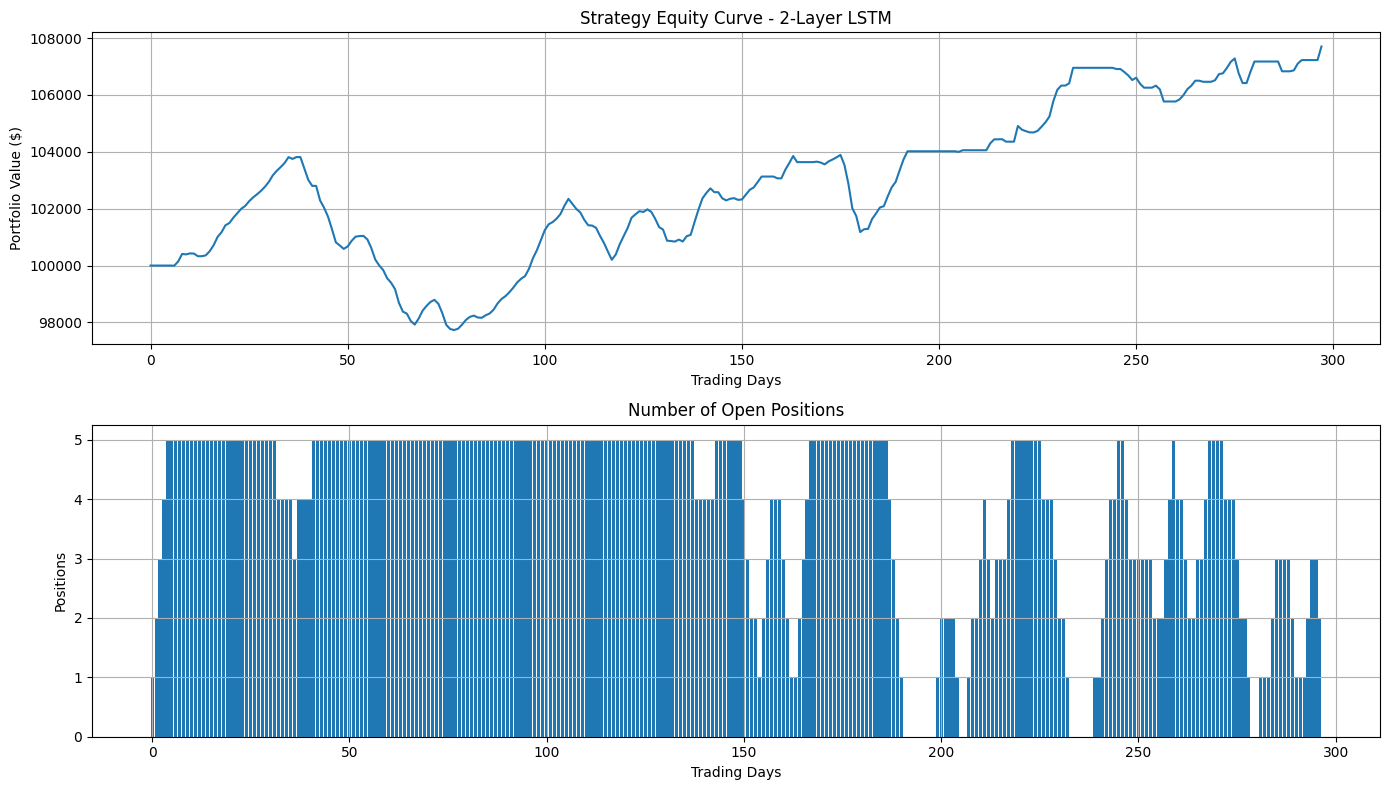


Strategy Performance Summary for 2-Layer LSTM:
Total Return: 7.70%
Annualized Return: 6.48%
Annualized Volatility: 3.15%
Sharpe Ratio: 2.05
Maximum Drawdown: 5.86%
Win Rate: 61.67%
Number of Trades: 227
Implementing Options Trading Strategy for 3-Layer LSTM
--------------------------------------
Creating volatility surfaces...
Creating LSTM input sequences...
Generating volatility surface predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Prediction completed in 0.76 seconds
Generating trading signals...
Determining option trades...
Applying risk management...
Running backtest...
Visualizing results...


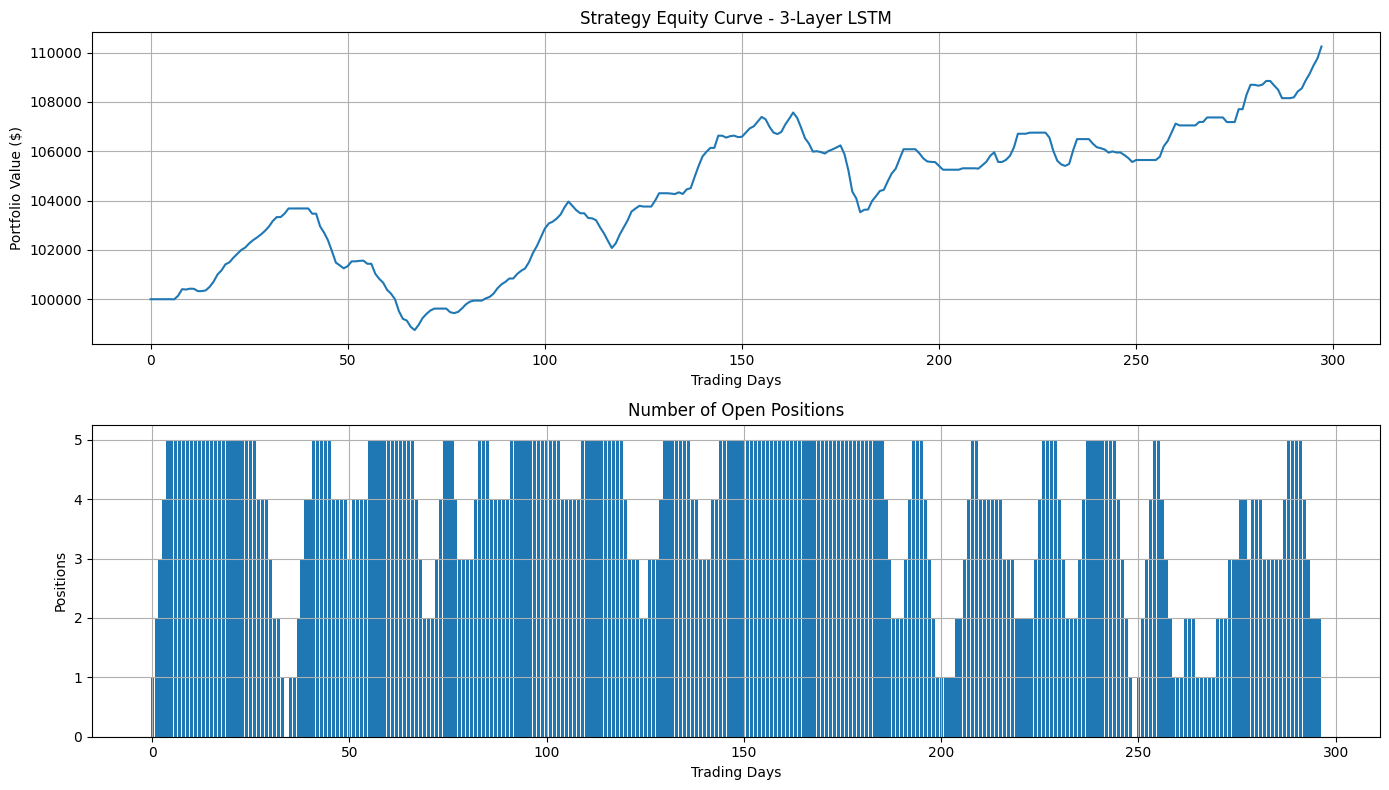


Strategy Performance Summary for 3-Layer LSTM:
Total Return: 10.25%
Annualized Return: 8.60%
Annualized Volatility: 3.20%
Sharpe Ratio: 2.69
Maximum Drawdown: 4.76%
Win Rate: 61.74%
Number of Trades: 230
Implementing Options Trading Strategy for 4-Layer LSTM
--------------------------------------
Creating volatility surfaces...
Creating LSTM input sequences...
Generating volatility surface predictions...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Prediction completed in 1.03 seconds
Generating trading signals...
Determining option trades...
Applying risk management...
Running backtest...
Visualizing results...


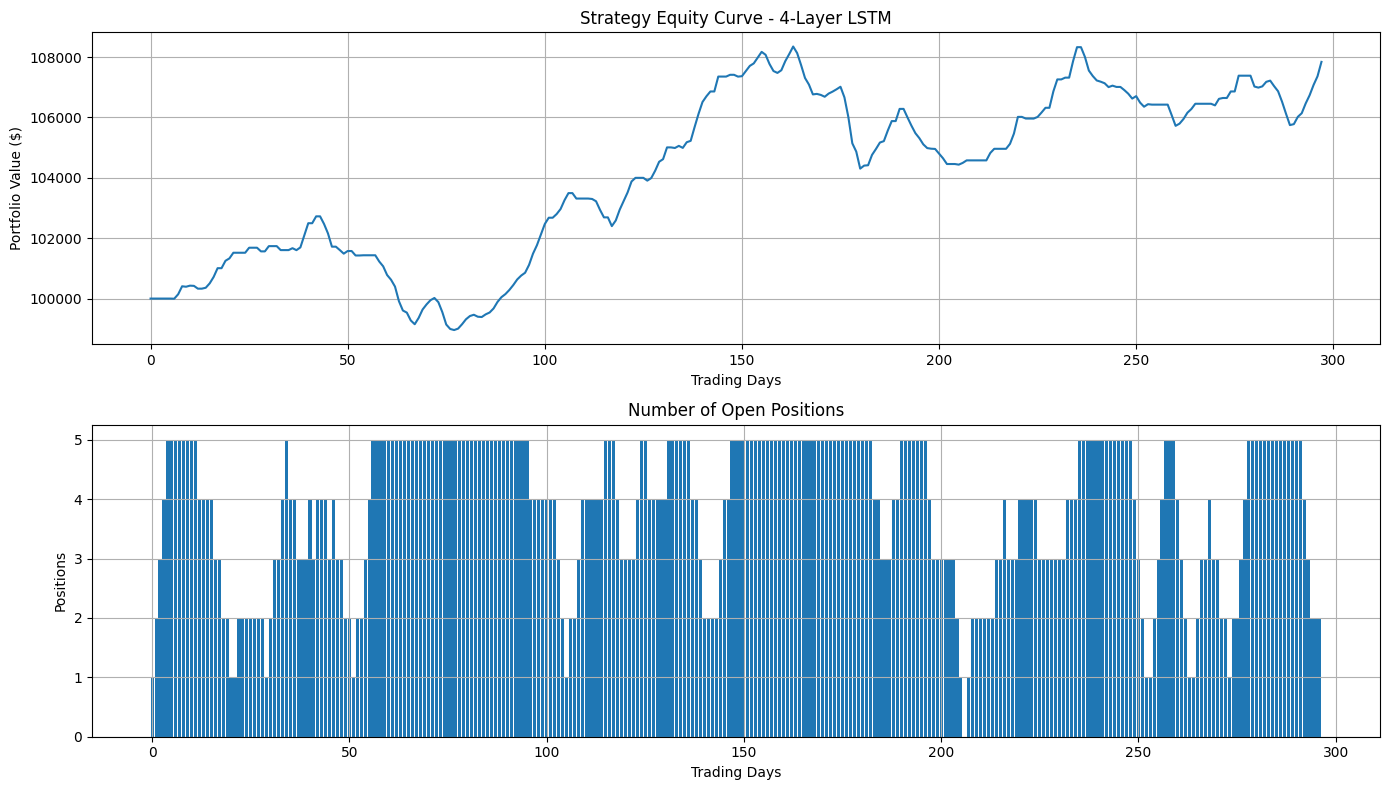


Strategy Performance Summary for 4-Layer LSTM:
Total Return: 7.84%
Annualized Return: 6.59%
Annualized Volatility: 3.18%
Sharpe Ratio: 2.07
Maximum Drawdown: 3.73%
Win Rate: 58.52%
Number of Trades: 229


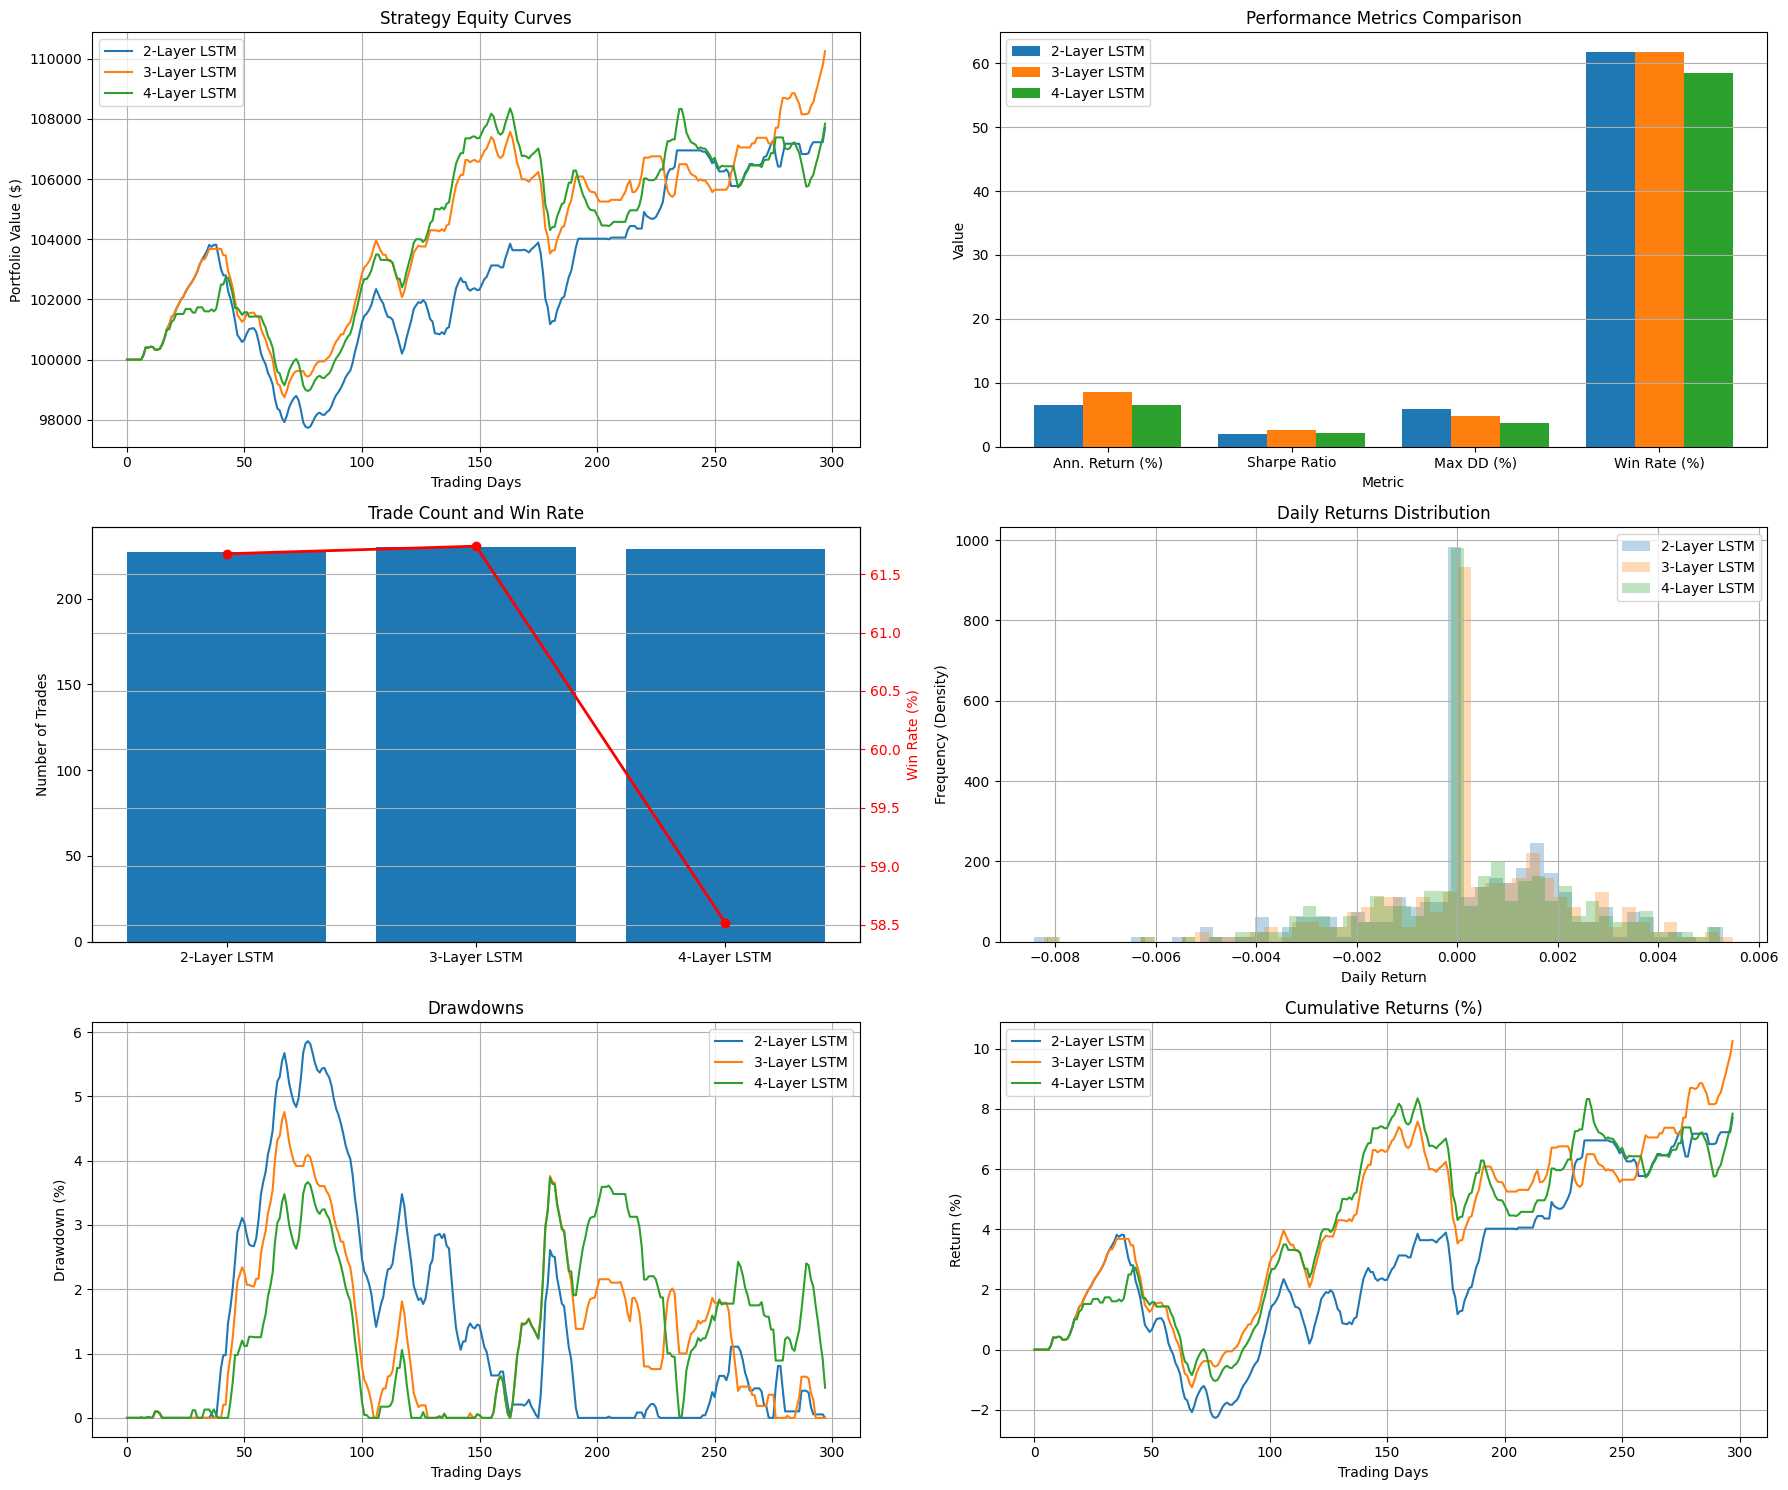


Detailed Strategy Comparison:
--------------------------------------------------------------------------------
Metric                    2-Layer LSTM    3-Layer LSTM    4-Layer LSTM   
--------------------------------------------------------------------------------
Total Return (%)          7.70            10.25           7.84           
Annualized Return (%)     6.48            8.60            6.59           
Annualized Volatility (%) 3.15            3.20            3.18           
Sharpe Ratio              2.05            2.69            2.07           
Maximum Drawdown (%)      5.86            4.76            3.73           
Win Rate (%)              61.67           61.74           58.52          
Number of Trades          227             230             229            
Prediction Time (s)       0.69            0.76            1.03           

Best performing model based on Sharpe ratio:
  3-Layer LSTM (Sharpe Ratio: 2.69)


In [ ]:
backtest_results_2layer = options_trading_strategy(model, data, lookback=20, test_size=0.2, model_name="2-Layer LSTM")
backtest_results_3layer = options_trading_strategy(medium_model, data, lookback=20, test_size=0.2, model_name="3-Layer LSTM")
backtest_results_4layer = options_trading_strategy(deeper_model, data, lookback=20, test_size=0.2, model_name="4-Layer LSTM")

# Compare results
backtest_results_list = [backtest_results_2layer, backtest_results_3layer, backtest_results_4layer]
model_names = ["2-Layer LSTM", "3-Layer LSTM", "4-Layer LSTM"]
comparison_results = compare_trading_strategies(backtest_results_list, model_names)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time

def mean_reversion_benchmark_strategy(data, lookback=20, test_size=0.2, window_size=30,
                                     z_score_threshold=1.0):

    print("Implementing Volatility Mean-Reversion Benchmark Strategy")
    print("--------------------------------------")

    print("Creating volatility surfaces...")

    unique_dates = sorted(data['date'].unique())
    moneyness_levels = sorted(data['moneyness_bucket'].unique())
    expiry_buckets = sorted(data['expiry_bucket'].unique())

    calls = data[data['cp_flag'] == 'C'].copy()

    underlying_prices = {}
    for date, group in data.groupby('date'):
        underlying_prices[date] = group['underlying_price'].iloc[0]

    vol_surfaces = {}
    for date in unique_dates:
        day_data = calls[calls['date'] == date]

        # Create a surface
        surface = np.zeros((len(moneyness_levels), len(expiry_buckets)))
        surface.fill(np.nan)

        for i, m in enumerate(moneyness_levels):
            for j, e in enumerate(expiry_buckets):
                subset = day_data[(day_data['moneyness_bucket'] == m) &
                                 (day_data['expiry_bucket'] == e)]
                if not subset.empty:
                    surface[i, j] = subset['impl_volatility'].mean()


        for j in range(surface.shape[1]):
            col = surface[:, j]
            mask = ~np.isnan(col)
            if np.sum(mask) > 1:
                indices = np.arange(surface.shape[0])
                interp_func = interpolate.interp1d(
                    indices[mask], col[mask],
                    bounds_error=False, fill_value="extrapolate"
                )
                surface[:, j] = interp_func(indices)

        for i in range(surface.shape[0]):
            row = surface[i, :]
            mask = ~np.isnan(row)
            if np.sum(mask) > 1:
                indices = np.arange(surface.shape[1])
                interp_func = interpolate.interp1d(
                    indices[mask], row[mask],
                    bounds_error=False, fill_value="extrapolate"
                )
                surface[i, :] = interp_func(indices)

        mean_val = np.nanmean(surface)
        surface[np.isnan(surface)] = mean_val

        vol_surfaces[date] = surface

    dates = sorted(list(vol_surfaces.keys()))
    train_size = int(len(dates) * (1 - test_size))
    train_dates = dates[:train_size]
    test_dates = dates[train_size:]

    print("Implementing mean-reversion strategy...")

    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()
    exp_30_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

    vol_tracker = pd.DataFrame({
        'date': dates,
        'atm_vol': [vol_surfaces[date][atm_idx, exp_30_idx] for date in dates]
    })

    vol_tracker['rolling_mean'] = vol_tracker['atm_vol'].rolling(window=window_size, min_periods=1).mean()
    vol_tracker['rolling_std'] = vol_tracker['atm_vol'].rolling(window=window_size, min_periods=1).std()


    vol_tracker['z_score'] = (vol_tracker['atm_vol'] - vol_tracker['rolling_mean']) / vol_tracker['rolling_std']

    vol_tracker['signal'] = 0.0

    vol_tracker.loc[vol_tracker['z_score'] > z_score_threshold, 'signal'] = -vol_tracker.loc[vol_tracker['z_score'] > z_score_threshold, 'z_score']

    vol_tracker.loc[vol_tracker['z_score'] < -z_score_threshold, 'signal'] = -vol_tracker.loc[vol_tracker['z_score'] < -z_score_threshold, 'z_score']

    test_vol_tracker = vol_tracker[vol_tracker['date'].isin(test_dates)].copy()

    date_to_idx = {date: i for i, date in enumerate(test_dates)}

    signals = {}
    trades = {}
    risk_managed_trades = {}

    capital = 100000
    max_risk_per_trade = 0.02

    for _, row in test_vol_tracker.iterrows():
        date = row['date']
        signal = row['signal']

        if signal == 0:
            signals[date] = 0
            trades[date] = {
                'direction': 'NO_TRADE',
                'instrument': None,
                'signal': 0
            }
            risk_managed_trades[date] = {
                'direction': 'NO_TRADE',
                'instrument': None,
                'signal': 0,
                'position_size': 0,
                'risk_fraction': 0
            }
            continue


        signals[date] = signal

        if signal > 0:
            direction = 'LONG_VOL'
            instrument = 'ATM_STRADDLE'
        else:
            direction = 'SHORT_VOL'
            instrument = 'ATM_STRADDLE'

        trades[date] = {
            'direction': direction,
            'instrument': instrument,
            'signal': abs(signal)
        }

        risk_fraction = min(abs(signal) * 0.5, max_risk_per_trade)  # Scale by signal strength
        position_size = capital * risk_fraction

        risk_managed_trades[date] = {
            'direction': direction,
            'instrument': instrument,
            'signal': abs(signal),
            'position_size': position_size,
            'risk_fraction': risk_fraction
        }

    print("Running backtest...")

    test_surfaces = np.array([vol_surfaces[date] for date in test_dates])

    def backtest_strategy(risk_managed_trades, actual_surfaces, dates,
                         moneyness_levels, expiry_buckets, underlying_prices):

        capital = 100000
        initial_capital = capital
        daily_returns = []
        equity_curve = [capital]
        positions = []
        trades_log = []

        atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()
        exp_30_idx = np.abs(np.array(expiry_buckets) - 30).argmin()

        open_positions = []

        for i in range(1, len(dates)):
            current_date = dates[i]
            prev_date = dates[i-1]

            current_price = underlying_prices[current_date]
            prev_price = underlying_prices[prev_date]
            current_vol = actual_surfaces[i][atm_idx, exp_30_idx]

            day_pnl = 0
            closed_positions = []

            for j, position in enumerate(open_positions):
                entry_date, direction, entry_vol, position_size = position
                days_held = (dates.index(current_date) - dates.index(entry_date))

                if days_held >= 5:
                    if direction == 'LONG_VOL':
                        # For long straddle, profit when vol increases
                        vol_change = current_vol - entry_vol
                        pnl_pct = vol_change / entry_vol
                        position_pnl = position_size * pnl_pct
                    else:  # 'SHORT_VOL'
                        # For short straddle, profit when vol decreases
                        vol_change = entry_vol - current_vol
                        pnl_pct = vol_change / entry_vol
                        position_pnl = position_size * pnl_pct

                    day_pnl += position_pnl
                    closed_positions.append(j)

                    trades_log.append({
                        'entry_date': entry_date,
                        'exit_date': current_date,
                        'direction': direction,
                        'position_size': position_size,
                        'entry_vol': entry_vol,
                        'exit_vol': current_vol,
                        'pnl': position_pnl,
                        'pnl_pct': pnl_pct * 100
                    })

            for j in sorted(closed_positions, reverse=True):
                open_positions.pop(j)

            if current_date in risk_managed_trades:
                trade = risk_managed_trades[current_date]

                if trade['direction'] != 'NO_TRADE':
                    position_size = trade['position_size']
                    open_positions.append([
                        current_date,
                        trade['direction'],
                        current_vol,
                        position_size
                    ])

            capital += day_pnl


            daily_return = day_pnl / equity_curve[-1] if equity_curve[-1] > 0 else 0
            daily_returns.append(daily_return)

            equity_curve.append(capital)

            positions.append(len(open_positions))

        total_return = (capital / initial_capital - 1) * 100

        num_years = len(dates) / 252
        annualized_return = ((capital / initial_capital) ** (1/num_years) - 1) * 100

        daily_returns_arr = np.array(daily_returns)
        annualized_vol = np.std(daily_returns_arr) * np.sqrt(252) * 100

        sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0

        running_max = np.maximum.accumulate(equity_curve)
        drawdowns = (running_max - equity_curve) / running_max * 100
        max_drawdown = np.max(drawdowns)

        winning_trades = sum(1 for trade in trades_log if trade['pnl'] > 0)
        win_rate = winning_trades / len(trades_log) if trades_log else 0

        results = {
            'equity_curve': equity_curve,
            'daily_returns': daily_returns,
            'trades': trades_log,
            'positions': positions,
            'total_return': total_return,
            'annualized_return': annualized_return,
            'annualized_volatility': annualized_vol,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'num_trades': len(trades_log)
        }

        return results

    backtest_results = backtest_strategy(
        risk_managed_trades=risk_managed_trades,
        actual_surfaces=test_surfaces,
        dates=test_dates,
        moneyness_levels=moneyness_levels,
        expiry_buckets=expiry_buckets,
        underlying_prices=underlying_prices
    )

    print("Visualizing results...")

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.plot(backtest_results['equity_curve'])
    plt.title('Mean-Reversion Strategy Equity Curve')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.bar(range(len(backtest_results['positions'])), backtest_results['positions'])
    plt.title('Number of Open Positions')
    plt.xlabel('Trading Days')
    plt.ylabel('Positions')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('mean_reversion_equity_curve.png')
    plt.show()

    plt.figure(figsize=(14, 8))

    # Get ATM volatility and signals
    atm_vols = [vol_surfaces[date][atm_idx, exp_30_idx] for date in test_dates]
    signal_values = [signals.get(date, 0) for date in test_dates]

    plt.subplot(2, 1, 1)
    plt.plot(atm_vols)
    plt.title('ATM Implied Volatility')
    plt.xlabel('Trading Days')
    plt.ylabel('Implied Volatility')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.bar(range(len(signal_values)), signal_values)
    plt.title('Mean-Reversion Trading Signals')
    plt.xlabel('Trading Days')
    plt.ylabel('Signal Strength')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('mean_reversion_signals.png')
    plt.show()

    print(f"\nMean-Reversion Strategy Performance Summary:")
    print(f"Total Return: {backtest_results['total_return']:.2f}%")
    print(f"Annualized Return: {backtest_results['annualized_return']:.2f}%")
    print(f"Annualized Volatility: {backtest_results['annualized_volatility']:.2f}%")
    print(f"Sharpe Ratio: {backtest_results['sharpe_ratio']:.2f}")
    print(f"Maximum Drawdown: {backtest_results['max_drawdown']:.2f}%")
    print(f"Win Rate: {backtest_results['win_rate']*100:.2f}%")
    print(f"Number of Trades: {backtest_results['num_trades']}")

    print("\nMean-Reversion Strategy Specific Metrics:")

    test_vol_tracker['next_day_vol_change'] = test_vol_tracker['atm_vol'].shift(-1) - test_vol_tracker['atm_vol']
    correlation = test_vol_tracker['z_score'].iloc[:-1].corr(test_vol_tracker['next_day_vol_change'].iloc[:-1])
    print(f"Correlation between Z-score and Next-Day Volatility Change: {correlation:.4f}")

    correct_predictions = 0
    total_signals = 0

    for i in range(len(test_vol_tracker) - 1):

        if test_vol_tracker['signal'].iloc[i] == 0:
            continue

        total_signals += 1

        if (test_vol_tracker['signal'].iloc[i] > 0 and
            test_vol_tracker['next_day_vol_change'].iloc[i] > 0) or \
           (test_vol_tracker['signal'].iloc[i] < 0 and
            test_vol_tracker['next_day_vol_change'].iloc[i] < 0):
            correct_predictions += 1

    hit_rate = correct_predictions / total_signals if total_signals > 0 else 0
    print(f"Signal Direction Hit Rate: {hit_rate*100:.2f}%")

    backtest_results['model_name'] = "Mean-Reversion"
    backtest_results['prediction_time'] = 0
    backtest_results['X_test'] = None
    backtest_results['y_test'] = test_surfaces
    backtest_results['y_pred'] = None
    backtest_results['test_dates'] = test_dates
    backtest_results['moneyness_levels'] = moneyness_levels
    backtest_results['expiry_buckets'] = expiry_buckets

    return backtest_results

def compare_with_mean_reversion(mean_reversion_results, lstm_results_list, model_names):

    all_results = [mean_reversion_results] + lstm_results_list
    all_model_names = ["Mean-Reversion"] + model_names


    plt.figure(figsize=(18, 15))

    plt.subplot(3, 2, 1)
    for i, results in enumerate(all_results):
        plt.plot(results['equity_curve'], label=all_model_names[i])
    plt.title('Strategy Equity Curves')
    plt.xlabel('Trading Days')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 2)
    metrics = ['Ann. Return (%)', 'Sharpe Ratio', 'Max DD (%)', 'Win Rate (%)']
    x = np.arange(len(metrics))
    width = 0.8 / len(all_model_names)
    offsets = np.linspace(-(len(all_model_names)-1)*width/2, (len(all_model_names)-1)*width/2, len(all_model_names))

    for i, results in enumerate(all_results):
        values = [
            results['annualized_return'],
            results['sharpe_ratio'],
            results['max_drawdown'],
            results['win_rate'] * 100
        ]
        plt.bar(x + offsets[i], values, width, label=all_model_names[i])

    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(axis='y')

    plt.subplot(3, 2, 3)
    trade_counts = [results['num_trades'] for results in all_results]
    win_rates = [results['win_rate'] * 100 for results in all_results]

    ax1 = plt.gca()
    ax1.bar(all_model_names, trade_counts)
    ax1.set_ylabel('Number of Trades')
    ax1.set_title('Trade Count and Win Rate')
    ax1.tick_params(axis='x', rotation=45)

    ax2 = ax1.twinx()
    ax2.plot(all_model_names, win_rates, 'ro-', linewidth=2)
    ax2.set_ylabel('Win Rate (%)', color='r')
    ax2.tick_params(axis='y', colors='r')

    plt.grid(True)

    plt.subplot(3, 2, 4)
    for i, results in enumerate(all_results):
        plt.hist(results['daily_returns'], bins=50, alpha=0.3, label=all_model_names[i], density=True)
    plt.title('Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency (Density)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 5)
    for i, results in enumerate(all_results):
        equity_curve = np.array(results['equity_curve'])
        running_max = np.maximum.accumulate(equity_curve)
        drawdowns = (running_max - equity_curve) / running_max * 100
        plt.plot(drawdowns, label=all_model_names[i])
    plt.title('Drawdowns')
    plt.xlabel('Trading Days')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 6)
    benchmark_returns = np.array(mean_reversion_results['equity_curve']) / mean_reversion_results['equity_curve'][0]

    for i, results in enumerate(lstm_results_list):
        model_returns = np.array(results['equity_curve']) / results['equity_curve'][0]

        min_length = min(len(benchmark_returns), len(model_returns))
        benchmark_returns_trimmed = benchmark_returns[:min_length]
        model_returns_trimmed = model_returns[:min_length]

        relative_performance = model_returns_trimmed / benchmark_returns_trimmed - 1
        plt.plot(relative_performance * 100, label=model_names[i])

    plt.title('LSTM Models Performance Relative to Benchmark (%)')
    plt.xlabel('Trading Days')
    plt.ylabel('Relative Performance (%)')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('benchmark_comparison.png')
    plt.show()

    print("\nDetailed Comparison with Benchmark:")
    print("-" * 80)
    print(f"{'Metric':<25} " + " ".join(f"{name:<15}" for name in all_model_names))
    print("-" * 80)

    metrics_to_compare = [
        ('Total Return (%)', 'total_return', '.2f'),
        ('Annualized Return (%)', 'annualized_return', '.2f'),
        ('Annualized Volatility (%)', 'annualized_volatility', '.2f'),
        ('Sharpe Ratio', 'sharpe_ratio', '.2f'),
        ('Maximum Drawdown (%)', 'max_drawdown', '.2f'),
        ('Win Rate (%)', lambda x: x['win_rate'] * 100, '.2f'),
        ('Number of Trades', 'num_trades', 'd')
    ]

    for metric_name, metric_key, format_spec in metrics_to_compare:
        metric_values = []
        for results in all_results:
            if callable(metric_key):
                value = metric_key(results)
            else:
                value = results.get(metric_key, None)

            if value is not None:
                metric_values.append(f"{value:{format_spec}}")
            else:
                metric_values.append("N/A")

        print(f"{metric_name:<25} " + " ".join(f"{val:<15}" for val in metric_values))

    benchmark_sharpe = mean_reversion_results['sharpe_ratio']
    benchmark_return = mean_reversion_results['annualized_return']

    print("\nPerformance Relative to Benchmark:")
    print("-" * 80)
    for i, name in enumerate(model_names):
        sharpe_improvement = (lstm_results_list[i]['sharpe_ratio'] / benchmark_sharpe - 1) * 100
        return_improvement = lstm_results_list[i]['annualized_return'] - benchmark_return

        print(f"{name}:")
        print(f"  Sharpe Ratio Improvement: {sharpe_improvement:+.2f}%")
        print(f"  Annualized Return Difference: {return_improvement:+.2f} percentage points")

    sharpe_ratios = [results['sharpe_ratio'] for results in all_results]
    best_idx = np.argmax(sharpe_ratios)

    print("\nBest performing model based on Sharpe ratio:")
    print(f"  {all_model_names[best_idx]} (Sharpe Ratio: {sharpe_ratios[best_idx]:.2f})")

    print("\nStatistical Analysis:")
    benchmark_returns = np.array(mean_reversion_results['daily_returns'])

    for i, name in enumerate(model_names):
        model_returns = np.array(lstm_results_list[i]['daily_returns'])

        min_length = min(len(benchmark_returns), len(model_returns))
        benchmark_returns_trimmed = benchmark_returns[:min_length]
        model_returns_trimmed = model_returns[:min_length]

        return_diff = np.mean(model_returns_trimmed) - np.mean(benchmark_returns_trimmed)
        pooled_std = np.sqrt((np.var(model_returns_trimmed) + np.var(benchmark_returns_trimmed)) / 2)
        t_stat = return_diff / (pooled_std / np.sqrt(min_length))

        from scipy import stats
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), 2*min_length - 2))

        print(f"{name} vs Benchmark:")
        print(f"  Mean Daily Return Difference: {return_diff*100:.6f}%")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  Approximate p-value: {p_value:.4f}")
        print(f"  Statistically Significant: {'Yes' if p_value < 0.05 else 'No'}")

    return {
        'benchmark_performance': {
            'sharpe_ratio': mean_reversion_results['sharpe_ratio'],
            'annualized_return': mean_reversion_results['annualized_return'],
            'max_drawdown': mean_reversion_results['max_drawdown'],
            'win_rate': mean_reversion_results['win_rate']
        },
        'best_model': all_model_names[best_idx],
        'metrics': {name: {
            'sharpe_ratio': results['sharpe_ratio'],
            'annualized_return': results['annualized_return'],
            'sharpe_improvement': (results['sharpe_ratio'] / benchmark_sharpe - 1) * 100,
            'return_improvement': results['annualized_return'] - benchmark_return
        } for name, results in zip(model_names, lstm_results_list)}
    }

Implementing Volatility Mean-Reversion Benchmark Strategy
--------------------------------------
Creating volatility surfaces...
Implementing mean-reversion strategy...
Running backtest...
Visualizing results...


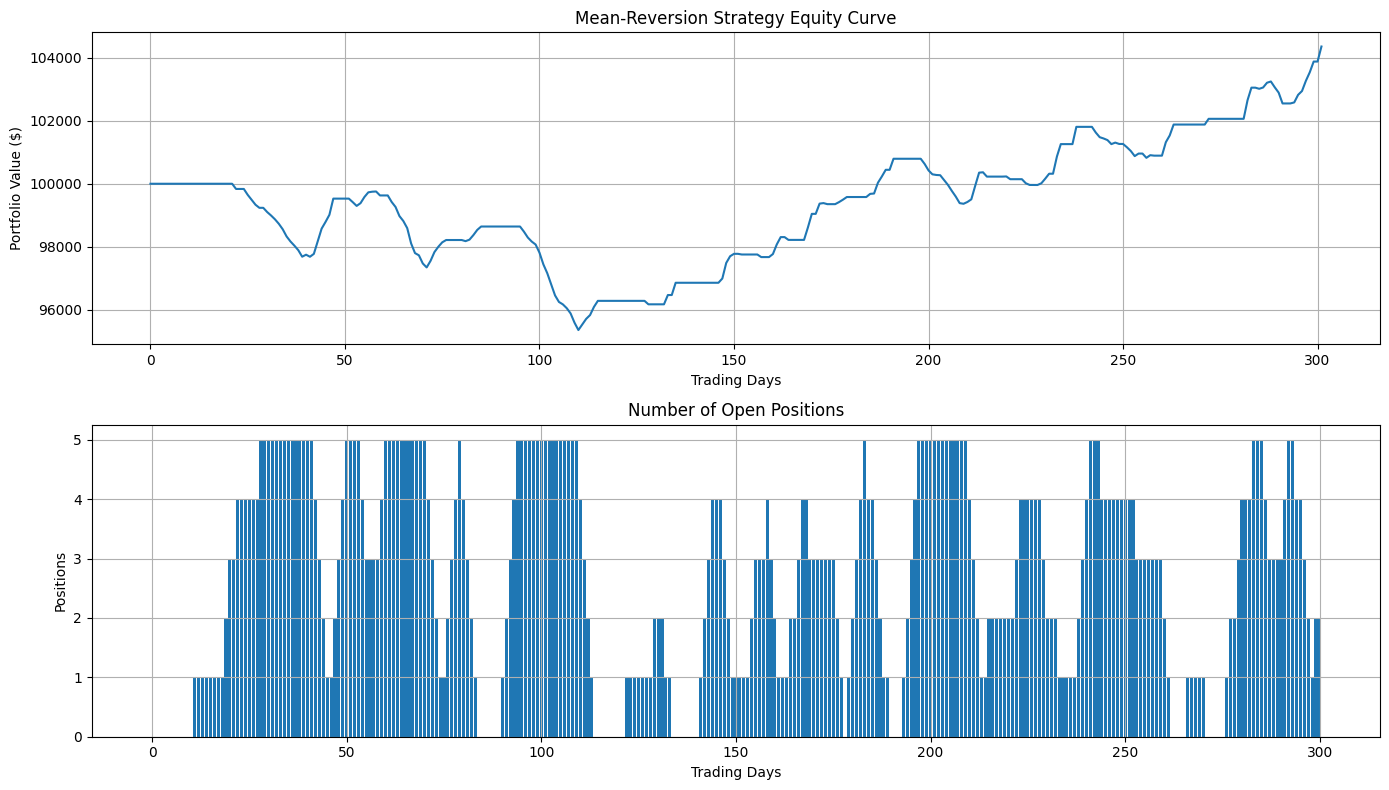

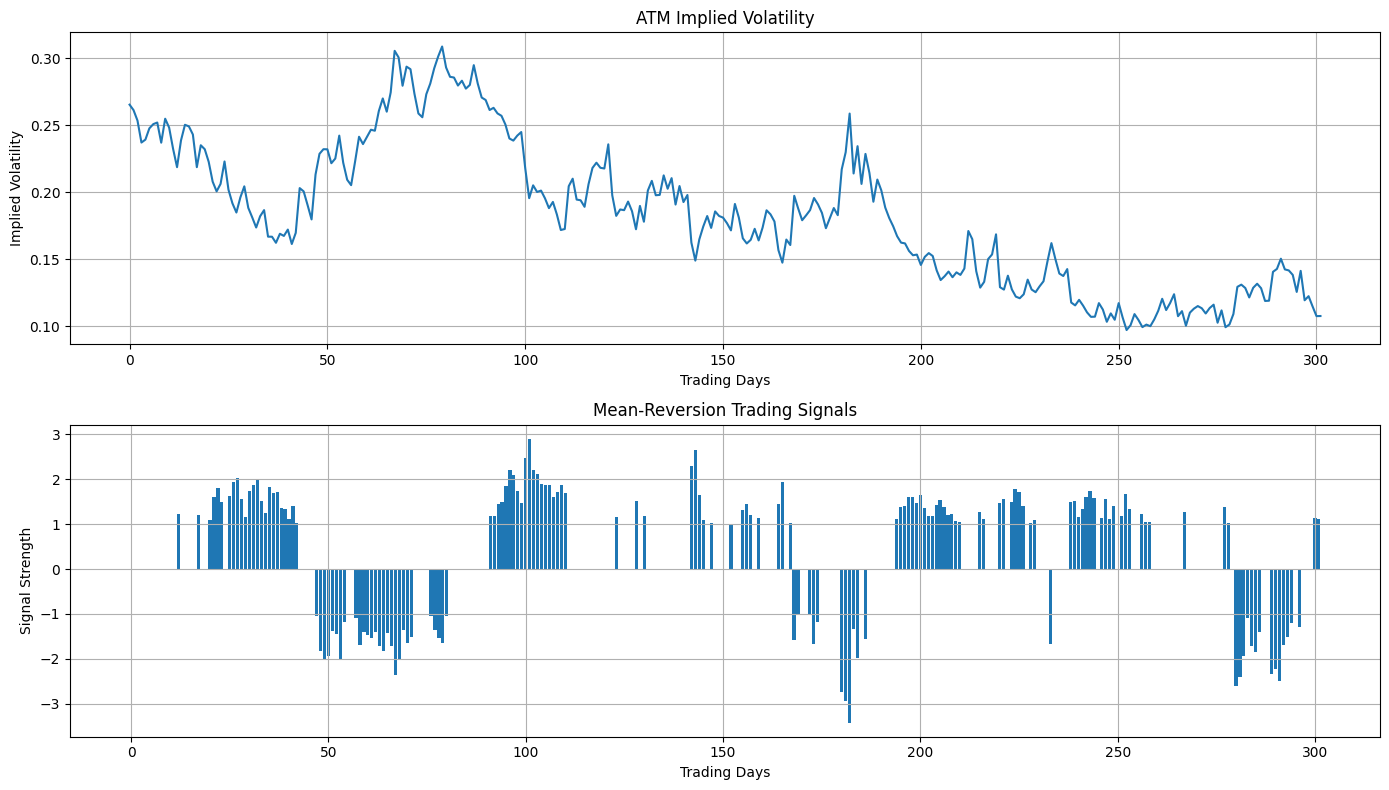


Mean-Reversion Strategy Performance Summary:
Total Return: 4.36%
Annualized Return: 3.62%
Annualized Volatility: 2.58%
Sharpe Ratio: 1.40
Maximum Drawdown: 4.64%
Win Rate: 49.69%
Number of Trades: 161

Mean-Reversion Strategy Specific Metrics:
Correlation between Z-score and Next-Day Volatility Change: -0.1175
Signal Direction Hit Rate: 54.94%


In [ ]:
benchmark_results = mean_reversion_benchmark_strategy(data, window_size=30, z_score_threshold=1.0)

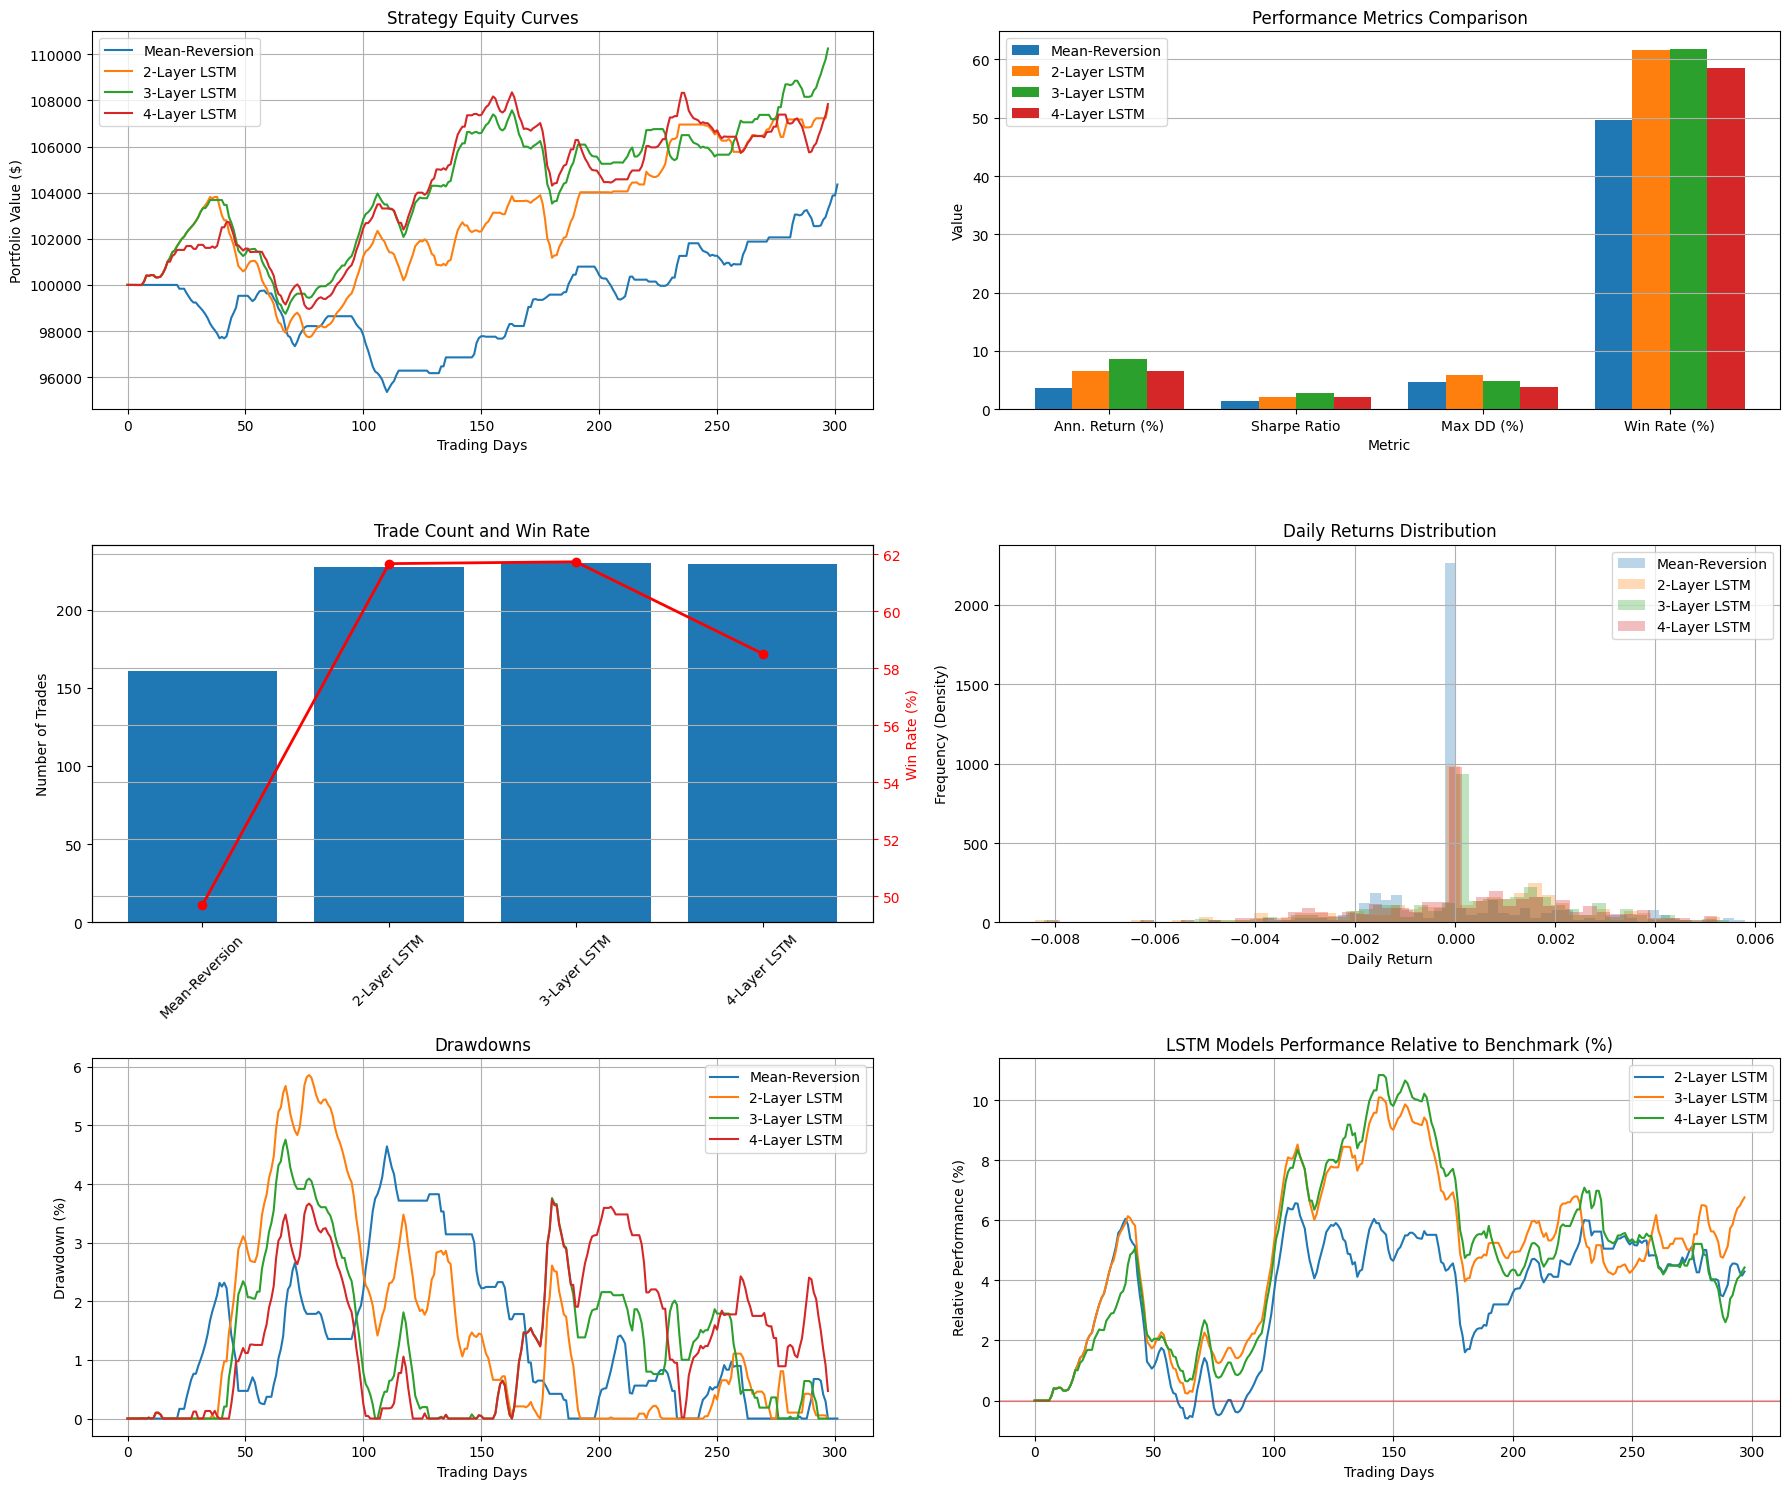


Detailed Comparison with Benchmark:
--------------------------------------------------------------------------------
Metric                    Mean-Reversion  2-Layer LSTM    3-Layer LSTM    4-Layer LSTM   
--------------------------------------------------------------------------------
Total Return (%)          4.36            7.70            10.25           7.84           
Annualized Return (%)     3.62            6.48            8.60            6.59           
Annualized Volatility (%) 2.58            3.15            3.20            3.18           
Sharpe Ratio              1.40            2.05            2.69            2.07           
Maximum Drawdown (%)      4.64            5.86            4.76            3.73           
Win Rate (%)              49.69           61.67           61.74           58.52          
Number of Trades          161             227             230             229            

Performance Relative to Benchmark:
---------------------------------------------

In [ ]:
lstm_results_list = [backtest_results_2layer, backtest_results_3layer, backtest_results_4layer]
model_names = ["2-Layer LSTM", "3-Layer LSTM", "4-Layer LSTM"]
comparison_results = compare_with_mean_reversion(benchmark_results, lstm_results_list, model_names)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

def regression_analysis(data, lstm_results_list, model_names, benchmark_results):

    print("Performing Regression Analysis")
    print("-----------------------------")

    regression_data = prepare_regression_data(data, lstm_results_list, model_names, benchmark_results)

    regression_results = {}

    alpha_beta_results = alpha_beta_analysis(regression_data, model_names)
    regression_results['alpha_beta'] = alpha_beta_results

    feature_importance_results = feature_importance_analysis(regression_data, model_names)
    regression_results['feature_importance'] = feature_importance_results

    regime_regression_results = regime_dependent_analysis(regression_data, model_names)
    regression_results['regime_dependent'] = regime_regression_results

    persistence_results = signal_persistence_analysis(regression_data, model_names)
    regression_results['persistence'] = persistence_results

    print_regression_summary(regression_results, model_names)

    return regression_results

def prepare_regression_data(data, lstm_results_list, model_names, benchmark_results):

    print("Preparing data for regression analysis...")

    test_dates = benchmark_results['test_dates']

    benchmark_signals = []
    for date in test_dates:
        if date in benchmark_results.get('trades', {}):
            trade = benchmark_results['trades'].get(date, {'signal': 0})
            if isinstance(trade, dict) and 'signal' in trade:
                signal = trade['signal'] if trade.get('direction', '') == 'LONG_VOL' else -trade['signal'] if trade.get('direction', '') == 'SHORT_VOL' else 0
                benchmark_signals.append(signal)
            else:
                benchmark_signals.append(0)
        else:
            benchmark_signals.append(0)

    benchmark_returns = benchmark_results['daily_returns']

    min_length = min(len(test_dates), len(benchmark_signals), len(benchmark_returns))

    regression_df = pd.DataFrame({
        'date': test_dates[:min_length],
        'benchmark_signal': benchmark_signals[:min_length],
        'benchmark_return': benchmark_returns[:min_length]
    })

    for i, (results, name) in enumerate(zip(lstm_results_list, model_names)):
        model_signals = []

        # Extract model signals
        for date in test_dates[:min_length]:
            if date in results.get('trades', {}):
                trade = results['trades'].get(date, {'signal': 0})
                if isinstance(trade, dict) and 'signal' in trade:
                    signal = trade['signal'] if trade.get('direction', '') == 'LONG_VOL' else -trade['signal'] if trade.get('direction', '') == 'SHORT_VOL' else 0
                    model_signals.append(signal)
                else:
                    model_signals.append(0)
            else:
                model_signals.append(0)

        if len(model_signals) > min_length:
            model_signals = model_signals[:min_length]
        elif len(model_signals) < min_length:
            model_signals = model_signals + [0] * (min_length - len(model_signals))

        model_returns = results['daily_returns']
        if len(model_returns) > min_length:
            model_returns = model_returns[:min_length]
        elif len(model_returns) < min_length:
            model_returns = model_returns + [0] * (min_length - len(model_returns))

        regression_df[f'{name}_signal'] = model_signals
        regression_df[f'{name}_return'] = model_returns

    print("Extracting volatility surface features...")

    moneyness_levels = sorted(data['moneyness_bucket'].unique())
    expiry_buckets = sorted(data['expiry_bucket'].unique())

    atm_idx = np.abs(np.array(moneyness_levels) - 1.0).argmin()
    otm_put_idx = np.abs(np.array(moneyness_levels) - 0.9).argmin()
    otm_call_idx = np.abs(np.array(moneyness_levels) - 1.1).argmin()
    short_exp_idx = np.abs(np.array(expiry_buckets) - 30).argmin()
    long_exp_idx = np.abs(np.array(expiry_buckets) - 90).argmin()

    vol_features = []

    for date in regression_df['date']:
        day_data = data[data['date'] == date]

        if day_data.empty:
            vol_features.append({
                'atm_vol': np.nan,
                'vol_skew': np.nan,
                'term_structure': np.nan,
                'vol_change_1d': np.nan,
                'vol_change_5d': np.nan
            })
            continue

        calls = day_data[day_data['cp_flag'] == 'C']

        atm_short = calls[(calls['moneyness_bucket'] == moneyness_levels[atm_idx]) &
                         (calls['expiry_bucket'] == expiry_buckets[short_exp_idx])]

        atm_vol = atm_short['impl_volatility'].mean() if not atm_short.empty else np.nan

        otm_put = calls[(calls['moneyness_bucket'] == moneyness_levels[otm_put_idx]) &
                       (calls['expiry_bucket'] == expiry_buckets[short_exp_idx])]

        otm_call = calls[(calls['moneyness_bucket'] == moneyness_levels[otm_call_idx]) &
                        (calls['expiry_bucket'] == expiry_buckets[short_exp_idx])]

        otm_put_vol = otm_put['impl_volatility'].mean() if not otm_put.empty else np.nan
        otm_call_vol = otm_call['impl_volatility'].mean() if not otm_call.empty else np.nan

        vol_skew = otm_put_vol - otm_call_vol

        atm_long = calls[(calls['moneyness_bucket'] == moneyness_levels[atm_idx]) &
                        (calls['expiry_bucket'] == expiry_buckets[long_exp_idx])]

        atm_long_vol = atm_long['impl_volatility'].mean() if not atm_long.empty else np.nan

        term_structure = atm_long_vol - atm_vol

        vol_features.append({
            'atm_vol': atm_vol,
            'vol_skew': vol_skew,
            'term_structure': term_structure,
            'vol_change_1d': np.nan,
            'vol_change_5d': np.nan
        })

    if len(vol_features) > len(regression_df):
        vol_features = vol_features[:len(regression_df)]
    elif len(vol_features) < len(regression_df):
        last_feature = vol_features[-1] if vol_features else {
            'atm_vol': np.nan, 'vol_skew': np.nan, 'term_structure': np.nan,
            'vol_change_1d': np.nan, 'vol_change_5d': np.nan
        }
        vol_features.extend([last_feature.copy() for _ in range(len(regression_df) - len(vol_features))])

    vol_features_df = pd.DataFrame(vol_features)

    for i in range(1, len(vol_features_df)):
        if pd.notna(vol_features_df['atm_vol'].iloc[i]) and pd.notna(vol_features_df['atm_vol'].iloc[i-1]):
            vol_features_df.loc[i, 'vol_change_1d'] = vol_features_df['atm_vol'].iloc[i] - vol_features_df['atm_vol'].iloc[i-1]

    for i in range(5, len(vol_features_df)):
        if pd.notna(vol_features_df['atm_vol'].iloc[i]) and pd.notna(vol_features_df['atm_vol'].iloc[i-5]):
            vol_features_df.loc[i, 'vol_change_5d'] = vol_features_df['atm_vol'].iloc[i] - vol_features_df['atm_vol'].iloc[i-5]

    vol_features_df['vol_regime'] = 'medium'
    vol_features_df.loc[vol_features_df['atm_vol'] <= vol_features_df['atm_vol'].quantile(0.33), 'vol_regime'] = 'low'
    vol_features_df.loc[vol_features_df['atm_vol'] >= vol_features_df['atm_vol'].quantile(0.67), 'vol_regime'] = 'high'

    vol_features_df['vol_trend'] = 'flat'
    vol_features_df.loc[vol_features_df['vol_change_5d'] > 0.01, 'vol_trend'] = 'rising'
    vol_features_df.loc[vol_features_df['vol_change_5d'] < -0.01, 'vol_trend'] = 'falling'

    vol_features_df['high_vol_regime'] = (vol_features_df['vol_regime'] == 'high').astype(int)
    vol_features_df['low_vol_regime'] = (vol_features_df['vol_regime'] == 'low').astype(int)
    vol_features_df['rising_vol'] = (vol_features_df['vol_trend'] == 'rising').astype(int)
    vol_features_df['falling_vol'] = (vol_features_df['vol_trend'] == 'falling').astype(int)

    try:
        underlying_returns = data.groupby('date')['underlying_price'].first().pct_change().fillna(0)
        regression_df['underlying_return'] = regression_df['date'].map(underlying_returns).fillna(0)
    except:
        regression_df['underlying_return'] = 0

    assert len(regression_df) == len(vol_features_df), f"Length mismatch: regression_df={len(regression_df)}, vol_features_df={len(vol_features_df)}"

    regression_data = pd.concat([regression_df.reset_index(drop=True),
                               vol_features_df.reset_index(drop=True)], axis=1)

    regression_data = regression_data.fillna(0)

    print(f"Prepared regression data with {len(regression_data)} rows and {regression_data.shape[1]} columns")

    return regression_data

def alpha_beta_analysis(regression_data, model_names):

    print("\nPerforming Alpha-Beta Analysis...")

    results = {}
    models = []

    for name in model_names:
        print(f"\nAnalyzing {name}...")

        y = regression_data[f'{name}_return']
        X = sm.add_constant(regression_data['benchmark_return'])

        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 10})

        alpha = model.params['const'] * 252  # Annualized alpha
        beta = model.params['benchmark_return']
        r_squared = model.rsquared
        alpha_tstat = model.tvalues['const']
        alpha_pval = model.pvalues['const']

        results[name] = {
            'model': model,
            'alpha': alpha,
            'beta': beta,
            'r_squared': r_squared,
            'alpha_tstat': alpha_tstat,
            'alpha_pval': alpha_pval
        }

        models.append(model)

        print(f"Alpha (annualized): {alpha*100:.4f}% (p-value: {alpha_pval:.4f})")
        print(f"Beta: {beta:.4f}")
        print(f"R-squared: {r_squared:.4f}")

    summary_table = summary_col(models,
                               model_names=model_names,
                               stars=True,
                               info_dict={'R-squared': lambda x: x.rsquared,
                                         'No. observations': lambda x: x.nobs})

    print("\nRegression Summary:")
    print(summary_table)

    plt.figure(figsize=(12, 8))

    for i, name in enumerate(model_names):
        plt.scatter(results[name]['beta'], results[name]['alpha']*100,
                    s=100, label=name)
        plt.annotate(name,
                    (results[name]['beta'], results[name]['alpha']*100),
                    xytext=(5, 5), textcoords='offset points')

    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.axvline(x=1, color='r', linestyle='-', alpha=0.3)

    plt.title('Alpha-Beta Analysis')
    plt.xlabel('Beta (Sensitivity to Benchmark)')
    plt.ylabel('Alpha (Annualized %)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('alpha_beta_analysis.png')
    plt.show()

    return results

def feature_importance_analysis(regression_data, model_names):

    print("\nPerforming Feature Importance Analysis...")

    results = {}

    vol_features = ['atm_vol', 'vol_skew', 'term_structure',
                   'vol_change_1d', 'vol_change_5d']

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(regression_data[vol_features])
    scaled_df = pd.DataFrame(scaled_features, columns=vol_features)

    for name in model_names:
        print(f"\nAnalyzing feature importance for {name}...")

        y_signal = regression_data[f'{name}_signal']
        X_signal = sm.add_constant(scaled_df)

        signal_model = sm.OLS(y_signal, X_signal).fit()

        y_return = regression_data[f'{name}_return']
        X_return = sm.add_constant(scaled_df)

        return_model = sm.OLS(y_return, X_return).fit()

        X_combined = sm.add_constant(pd.concat([
            pd.Series(regression_data['benchmark_return'], name='benchmark_return'),
            scaled_df
        ], axis=1))

        combined_model = sm.OLS(y_return, X_combined).fit()

        results[name] = {
            'signal_model': signal_model,
            'return_model': return_model,
            'combined_model': combined_model,
            'signal_rsquared': signal_model.rsquared,
            'return_rsquared': return_model.rsquared,
            'combined_rsquared': combined_model.rsquared
        }

        print(f"\nSignal Model R-squared: {signal_model.rsquared:.4f}")
        print("Top 3 features explaining signals:")
        signal_params = signal_model.params[1:].abs().sort_values(ascending=False)
        for feature, coef in signal_params.head(3).items():
            print(f"- {feature}: {coef:.4f} (p-value: {signal_model.pvalues[feature]:.4f})")

        print(f"\nReturn Model R-squared: {return_model.rsquared:.4f}")
        print("Top 3 features explaining returns:")
        return_params = return_model.params[1:].abs().sort_values(ascending=False)
        for feature, coef in return_params.head(3).items():
            print(f"- {feature}: {coef:.4f} (p-value: {return_model.pvalues[feature]:.4f})")

    plt.figure(figsize=(14, 10))

    n_features = len(vol_features)
    bar_width = 0.8 / len(model_names)
    offsets = np.linspace(-(len(model_names)-1)*bar_width/2, (len(model_names)-1)*bar_width/2, len(model_names))

    for i, name in enumerate(model_names):
        coeffs = np.array([results[name]['signal_model'].params[feature] for feature in vol_features])
        x = np.arange(n_features)
        plt.bar(x + offsets[i], coeffs, bar_width, label=name)

    plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    plt.xlabel('Volatility Surface Feature')
    plt.ylabel('Standardized Coefficient')
    plt.title('Feature Importance for Model Signals')
    plt.xticks(range(n_features), vol_features)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    correlation_matrix = regression_data[vol_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('feature_correlations.png')
    plt.show()

    return results

def regime_dependent_analysis(regression_data, model_names):

    print("\nPerforming Regime-Dependent Analysis...")

    results = {}

    regression_data['benchmark_x_highvol'] = regression_data['benchmark_return'] * regression_data['high_vol_regime']
    regression_data['benchmark_x_lowvol'] = regression_data['benchmark_return'] * regression_data['low_vol_regime']
    regression_data['benchmark_x_rising'] = regression_data['benchmark_return'] * regression_data['rising_vol']
    regression_data['benchmark_x_falling'] = regression_data['benchmark_return'] * regression_data['falling_vol']

    for name in model_names:
        print(f"\nAnalyzing regime dependence for {name}...")

        X_vol_regime = sm.add_constant(regression_data[['benchmark_return', 'high_vol_regime',
                                                     'low_vol_regime', 'benchmark_x_highvol',
                                                     'benchmark_x_lowvol']])
        y_vol = regression_data[f'{name}_return']

        vol_regime_model = sm.OLS(y_vol, X_vol_regime).fit()

        X_vol_trend = sm.add_constant(regression_data[['benchmark_return', 'rising_vol',
                                                     'falling_vol', 'benchmark_x_rising',
                                                     'benchmark_x_falling']])

        vol_trend_model = sm.OLS(y_vol, X_vol_trend).fit()

        results[name] = {
            'vol_regime_model': vol_regime_model,
            'vol_trend_model': vol_trend_model,
            'vol_regime_rsquared': vol_regime_model.rsquared,
            'vol_trend_rsquared': vol_trend_model.rsquared
        }

        alpha_baseline = vol_regime_model.params['const'] * 252
        beta_baseline = vol_regime_model.params['benchmark_return']

        alpha_high = alpha_baseline + vol_regime_model.params['high_vol_regime'] * 252
        beta_high = beta_baseline + vol_regime_model.params['benchmark_x_highvol']

        alpha_low = alpha_baseline + vol_regime_model.params['low_vol_regime'] * 252
        beta_low = beta_baseline + vol_regime_model.params['benchmark_x_lowvol']

        print(f"\nRegime-Dependent Performance:")
        print(f"Baseline: Alpha = {alpha_baseline*100:.4f}%, Beta = {beta_baseline:.4f}")
        print(f"High Vol: Alpha = {alpha_high*100:.4f}%, Beta = {beta_high:.4f}")
        print(f"Low Vol: Alpha = {alpha_low*100:.4f}%, Beta = {beta_low:.4f}")

        alpha_baseline_trend = vol_trend_model.params['const'] * 252
        beta_baseline_trend = vol_trend_model.params['benchmark_return']

        alpha_rising = alpha_baseline_trend + vol_trend_model.params['rising_vol'] * 252
        beta_rising = beta_baseline_trend + vol_trend_model.params['benchmark_x_rising']

        alpha_falling = alpha_baseline_trend + vol_trend_model.params['falling_vol'] * 252
        beta_falling = beta_baseline_trend + vol_trend_model.params['benchmark_x_falling']

        print(f"\nTrend-Dependent Performance:")
        print(f"Baseline: Alpha = {alpha_baseline_trend*100:.4f}%, Beta = {beta_baseline_trend:.4f}")
        print(f"Rising Vol: Alpha = {alpha_rising*100:.4f}%, Beta = {beta_rising:.4f}")
        print(f"Falling Vol: Alpha = {alpha_falling*100:.4f}%, Beta = {beta_falling:.4f}")

        results[name]['regime_alphas'] = {
            'baseline': alpha_baseline,
            'high_vol': alpha_high,
            'low_vol': alpha_low
        }

        results[name]['regime_betas'] = {
            'baseline': beta_baseline,
            'high_vol': beta_high,
            'low_vol': beta_low
        }

        results[name]['trend_alphas'] = {
            'baseline': alpha_baseline_trend,
            'rising': alpha_rising,
            'falling': alpha_falling
        }

        results[name]['trend_betas'] = {
            'baseline': beta_baseline_trend,
            'rising': beta_rising,
            'falling': beta_falling
        }

    plt.figure(figsize=(14, 8))

    plt.subplot(1, 2, 1)

    regimes = ['baseline', 'high_vol', 'low_vol']
    x = np.arange(len(regimes))
    width = 0.8 / len(model_names)
    offsets = np.linspace(-(len(model_names)-1)*width/2, (len(model_names)-1)*width/2, len(model_names))

    for i, name in enumerate(model_names):
        alphas = [results[name]['regime_alphas'][regime] * 100 for regime in regimes]
        plt.bar(x + offsets[i], alphas, width, label=name)

    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Alpha by Volatility Level Regime')
    plt.xlabel('Volatility Regime')
    plt.ylabel('Annualized Alpha (%)')
    plt.xticks(x, regimes)
    plt.legend()
    plt.grid(True, axis='y')

    plt.subplot(1, 2, 2)

    trends = ['baseline', 'rising', 'falling']
    x = np.arange(len(trends))

    for i, name in enumerate(model_names):
        alphas = [results[name]['trend_alphas'][trend] * 100 for trend in trends]
        plt.bar(x + offsets[i], alphas, width, label=name)

    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Alpha by Volatility Trend')
    plt.xlabel('Volatility Trend')
    plt.ylabel('Annualized Alpha (%)')
    plt.xticks(x, trends)
    plt.legend()
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig('regime_dependent_alphas.png')
    plt.show()

    return results

def signal_persistence_analysis(regression_data, model_names):

    print("\nPerforming Signal Persistence Analysis...")

    results = {}
    max_lag = 10

    for name in model_names:
        signal_col = f'{name}_signal'
        for lag in range(1, max_lag+1):
            regression_data[f'{signal_col}_lag{lag}'] = regression_data[signal_col].shift(lag)

    for lag in range(1, max_lag+1):
        regression_data[f'benchmark_signal_lag{lag}'] = regression_data['benchmark_signal'].shift(lag)

    lagged_data = regression_data.dropna()

    for name in model_names:
        print(f"\nAnalyzing signal persistence for {name}...")

        coeffs = []
        pvals = []
        r_squareds = []

        for lag in range(1, max_lag+1):
            y = lagged_data[f'{name}_return']
            X = sm.add_constant(lagged_data[f'{name}_signal_lag{lag}'])

            model = sm.OLS(y, X).fit()

            coef = model.params[f'{name}_signal_lag{lag}']
            pval = model.pvalues[f'{name}_signal_lag{lag}']
            r2 = model.rsquared

            coeffs.append(coef)
            pvals.append(pval)
            r_squareds.append(r2)

            print(f"Lag {lag}: Coefficient = {coef:.6f}, p-value = {pval:.4f}, R² = {r2:.4f}")

        if coeffs[0] > 0 and any(c < coeffs[0]/2 for c in coeffs):
            half_life = next(i+1 for i, c in enumerate(coeffs) if c < coeffs[0]/2)
        else:
            half_life = None

        results[name] = {
            'coefficients': coeffs,
            'p_values': pvals,
            'r_squareds': r_squareds,
            'half_life': half_life
        }

        print(f"Signal half-life: {half_life if half_life else 'Not determined'} days")

    benchmark_coeffs = []
    benchmark_pvals = []
    benchmark_r2s = []

    for lag in range(1, max_lag+1):
        y = lagged_data['benchmark_return']
        X = sm.add_constant(lagged_data[f'benchmark_signal_lag{lag}'])

        model = sm.OLS(y, X).fit()

        coef = model.params[f'benchmark_signal_lag{lag}']
        pval = model.pvalues[f'benchmark_signal_lag{lag}']
        r2 = model.rsquared

        benchmark_coeffs.append(coef)
        benchmark_pvals.append(pval)
        benchmark_r2s.append(r2)

    if benchmark_coeffs[0] > 0 and any(c < benchmark_coeffs[0]/2 for c in benchmark_coeffs):
        benchmark_half_life = next(i+1 for i, c in enumerate(benchmark_coeffs) if c < benchmark_coeffs[0]/2)
    else:
        benchmark_half_life = None

    results['benchmark'] = {
        'coefficients': benchmark_coeffs,
        'p_values': benchmark_pvals,
        'r_squareds': benchmark_r2s,
        'half_life': benchmark_half_life
    }

    print(f"\nBenchmark signal half-life: {benchmark_half_life if benchmark_half_life else 'Not determined'} days")

    plt.figure(figsize=(14, 8))

    plt.subplot(1, 2, 1)

    for name in model_names:
        plt.plot(range(1, max_lag+1), results[name]['coefficients'],
                marker='o', label=name)

    plt.plot(range(1, max_lag+1), benchmark_coeffs,
            marker='s', linestyle='--', color='black', label='Benchmark')

    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Signal Persistence by Lag')
    plt.xlabel('Lag (Days)')
    plt.ylabel('Signal Coefficient')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)

    for name in model_names:
        plt.plot(range(1, max_lag+1), results[name]['r_squareds'],
                marker='o', label=name)

    plt.plot(range(1, max_lag+1), benchmark_r2s,
            marker='s', linestyle='--', color='black', label='Benchmark')

    plt.title('Signal Explanatory Power by Lag')
    plt.xlabel('Lag (Days)')
    plt.ylabel('R-squared')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('signal_persistence.png')
    plt.show()

    return results

def print_regression_summary(regression_results, model_names):

    print("\n" + "="*80)
    print("REGRESSION ANALYSIS SUMMARY")
    print("="*80)

    print("\nALPHA-BETA ANALYSIS")
    print("-"*80)
    print(f"{'Model':<15} {'Alpha (%)':<12} {'p-value':<12} {'Beta':<10} {'R-squared':<12}")
    print("-"*80)

    for name in model_names:
        results = regression_results['alpha_beta'][name]
        alpha = results['alpha'] * 100
        alpha_pval = results['alpha_pval']
        beta = results['beta']
        r2 = results['r_squared']

        stars = ''
        if alpha_pval < 0.01:
            stars = '***'
        elif alpha_pval < 0.05:
            stars = '**'
        elif alpha_pval < 0.1:
            stars = '*'

        print(f"{name:<15} {alpha:>9.4f}{stars:<3} {alpha_pval:<12.4f} {beta:<10.4f} {r2:<12.4f}")

    print("\nFEATURE IMPORTANCE ANALYSIS")
    print("-"*80)

    vol_features = ['atm_vol', 'vol_skew', 'term_structure',
                   'vol_change_1d', 'vol_change_5d']

    for name in model_names:
        print(f"\n{name} Feature Importance:")

        signal_model = regression_results['feature_importance'][name]['signal_model']
        return_model = regression_results['feature_importance'][name]['return_model']

        signal_coeffs = [(f, signal_model.params[f], signal_model.pvalues[f])
                        for f in vol_features]
        signal_coeffs.sort(key=lambda x: abs(x[1]), reverse=True)

        return_coeffs = [(f, return_model.params[f], return_model.pvalues[f])
                        for f in vol_features]
        return_coeffs.sort(key=lambda x: abs(x[1]), reverse=True)

        print(f"  Signal Model R²: {signal_model.rsquared:.4f}")
        print(f"  {'Feature':<15} {'Coefficient':<12} {'p-value':<12} {'Significance':<12}")
        print(f"  {'-'*50}")

        for feature, coef, pval in signal_coeffs:
            stars = ''
            if pval < 0.01:
                stars = '***'
            elif pval < 0.05:
                stars = '**'
            elif pval < 0.1:
                stars = '*'

            print(f"  {feature:<15} {coef:>10.4f} {pval:<12.4f} {stars:<12}")

        print(f"\n  Return Model R²: {return_model.rsquared:.4f}")
        print(f"  {'Feature':<15} {'Coefficient':<12} {'p-value':<12} {'Significance':<12}")
        print(f"  {'-'*50}")

        for feature, coef, pval in return_coeffs:
            stars = ''
            if pval < 0.01:
                stars = '***'
            elif pval < 0.05:
                stars = '**'
            elif pval < 0.1:
                stars = '*'

            print(f"  {feature:<15} {coef:>10.4f} {pval:<12.4f} {stars:<12}")

    print("\nREGIME-DEPENDENT ANALYSIS")
    print("-"*80)

    for name in model_names:
        print(f"\n{name} Performance by Volatility Regime:")

        regime_alphas = regression_results['regime_dependent'][name]['regime_alphas']
        regime_betas = regression_results['regime_dependent'][name]['regime_betas']

        print(f"  {'Regime':<15} {'Alpha (%)':<12} {'Beta':<10}")
        print(f"  {'-'*40}")

        for regime in ['baseline', 'high_vol', 'low_vol']:
            alpha = regime_alphas[regime] * 100  # Convert to percentage
            beta = regime_betas[regime]

            print(f"  {regime:<15} {alpha:>10.4f} {beta:<10.4f}")

        print(f"\n{name} Performance by Volatility Trend:")

        trend_alphas = regression_results['regime_dependent'][name]['trend_alphas']
        trend_betas = regression_results['regime_dependent'][name]['trend_betas']

        print(f"  {'Trend':<15} {'Alpha (%)':<12} {'Beta':<10}")
        print(f"  {'-'*40}")

        for trend in ['baseline', 'rising', 'falling']:
            alpha = trend_alphas[trend] * 100  # Convert to percentage
            beta = trend_betas[trend]

            print(f"  {trend:<15} {alpha:>10.4f} {beta:<10.4f}")

    print("\nSIGNAL PERSISTENCE ANALYSIS")
    print("-"*80)

    print(f"{'Model':<15} {'Half-Life (days)':<20} {'Max Coefficient':<15} {'Max R-squared':<15}")
    print("-"*80)

    for name in model_names:
        hl = regression_results['persistence'][name]['half_life']
        max_coef = max(regression_results['persistence'][name]['coefficients']) if regression_results['persistence'][name]['coefficients'] else 0
        max_r2 = max(regression_results['persistence'][name]['r_squareds']) if regression_results['persistence'][name]['r_squareds'] else 0

        hl_str = str(hl) if hl is not None else "Not determined"

        print(f"{name:<15} {hl_str:<20} {max_coef:>15.6f} {max_r2:>15.4f}")

    hl = regression_results['persistence']['benchmark']['half_life']
    max_coef = max(regression_results['persistence']['benchmark']['coefficients']) if regression_results['persistence']['benchmark']['coefficients'] else 0
    max_r2 = max(regression_results['persistence']['benchmark']['r_squareds']) if regression_results['persistence']['benchmark']['r_squareds'] else 0

    hl_str = str(hl) if hl is not None else "Not determined"

    print(f"{'Benchmark':<15} {hl_str:<20} {max_coef:>15.6f} {max_r2:>15.4f}")

    print("\nOVERALL SUMMARY")
    print("-"*80)

    for name in model_names:
        alpha = regression_results['alpha_beta'][name]['alpha'] * 100
        alpha_sig = "Yes" if regression_results['alpha_beta'][name]['alpha_pval'] < 0.05 else "No"

        feat_importance = regression_results['feature_importance'][name]['signal_rsquared']
        top_feature = max([(f, abs(regression_results['feature_importance'][name]['signal_model'].params[f]))
                         for f in vol_features], key=lambda x: x[1])[0]

        best_regime = max([(r, regression_results['regime_dependent'][name]['regime_alphas'][r])
                         for r in ['baseline', 'high_vol', 'low_vol']], key=lambda x: x[1])[0]

        persistence = regression_results['persistence'][name]['half_life']
        pers_str = f"{persistence} days" if persistence is not None else "Not determined"

        print(f"\n{name}:")
        print(f"  - Alpha: {alpha:.4f}% (Significant: {alpha_sig})")
        print(f"  - Model Signal R²: {feat_importance:.4f}, Top Feature: {top_feature}")
        print(f"  - Best Performance in: {best_regime} volatility regime")
        print(f"  - Signal Persistence: {pers_str}")

    print("\n" + "="*80)


Performing Regression Analysis
-----------------------------
Preparing data for regression analysis...
Extracting volatility surface features...
Prepared regression data with 301 rows and 21 columns

Performing Alpha-Beta Analysis...

Analyzing 2-Layer LSTM...
Alpha (annualized): 6.5217% (p-value: 0.2043)
Beta: -0.0722
R-squared: 0.0035

Analyzing 3-Layer LSTM...
Alpha (annualized): 8.4494% (p-value: 0.0986)
Beta: -0.0634
R-squared: 0.0027

Analyzing 4-Layer LSTM...
Alpha (annualized): 6.4514% (p-value: 0.1872)
Beta: -0.0224
R-squared: 0.0003

Regression Summary:

                 2-Layer LSTM 3-Layer LSTM 4-Layer LSTM
-------------------------------------------------------
const            0.0003       0.0003*      0.0003      
                 (0.0002)     (0.0002)     (0.0002)    
benchmark_return -0.0722      -0.0634      -0.0224     
                 (0.1196)     (0.1197)     (0.0925)    
R-squared        0.0035       0.0027       0.0003      
R-squared Adj.   0.0002       -0.0007

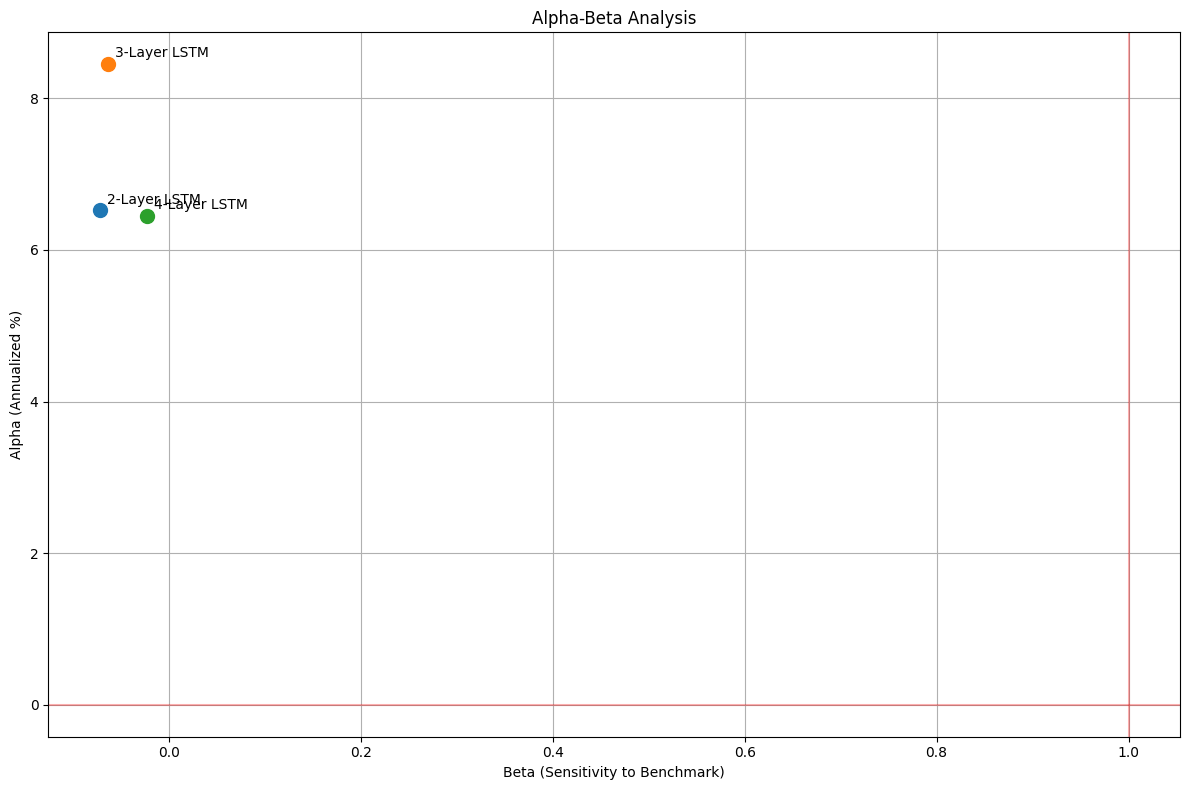


Performing Feature Importance Analysis...

Analyzing feature importance for 2-Layer LSTM...

Signal Model R-squared: nan
Top 3 features explaining signals:
- atm_vol: 0.0000 (p-value: nan)
- vol_skew: 0.0000 (p-value: nan)
- term_structure: 0.0000 (p-value: nan)

Return Model R-squared: 0.0441
Top 3 features explaining returns:
- term_structure: 0.0005 (p-value: 0.0073)
- atm_vol: 0.0001 (p-value: 0.4144)
- vol_change_1d: 0.0001 (p-value: 0.4975)

Analyzing feature importance for 3-Layer LSTM...

Signal Model R-squared: nan
Top 3 features explaining signals:
- atm_vol: 0.0000 (p-value: nan)
- vol_skew: 0.0000 (p-value: nan)
- term_structure: 0.0000 (p-value: nan)

Return Model R-squared: 0.0213
Top 3 features explaining returns:
- term_structure: 0.0003 (p-value: 0.0813)
- vol_change_5d: 0.0001 (p-value: 0.5474)
- vol_skew: 0.0000 (p-value: 0.7133)

Analyzing feature importance for 4-Layer LSTM...

Signal Model R-squared: nan
Top 3 features explaining signals:
- atm_vol: 0.0000 (p-val

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


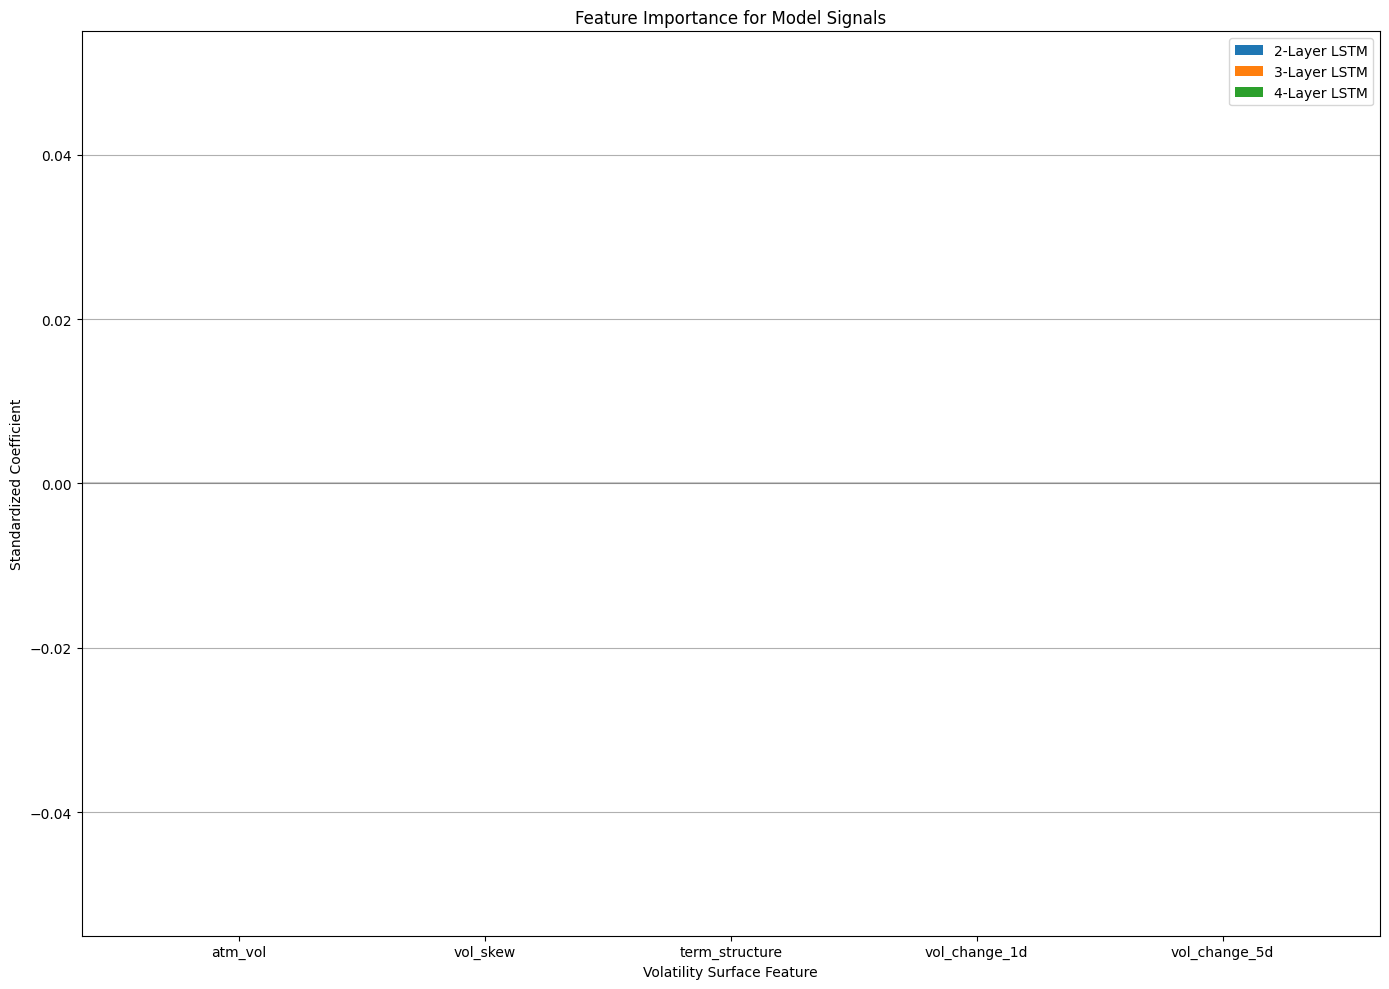

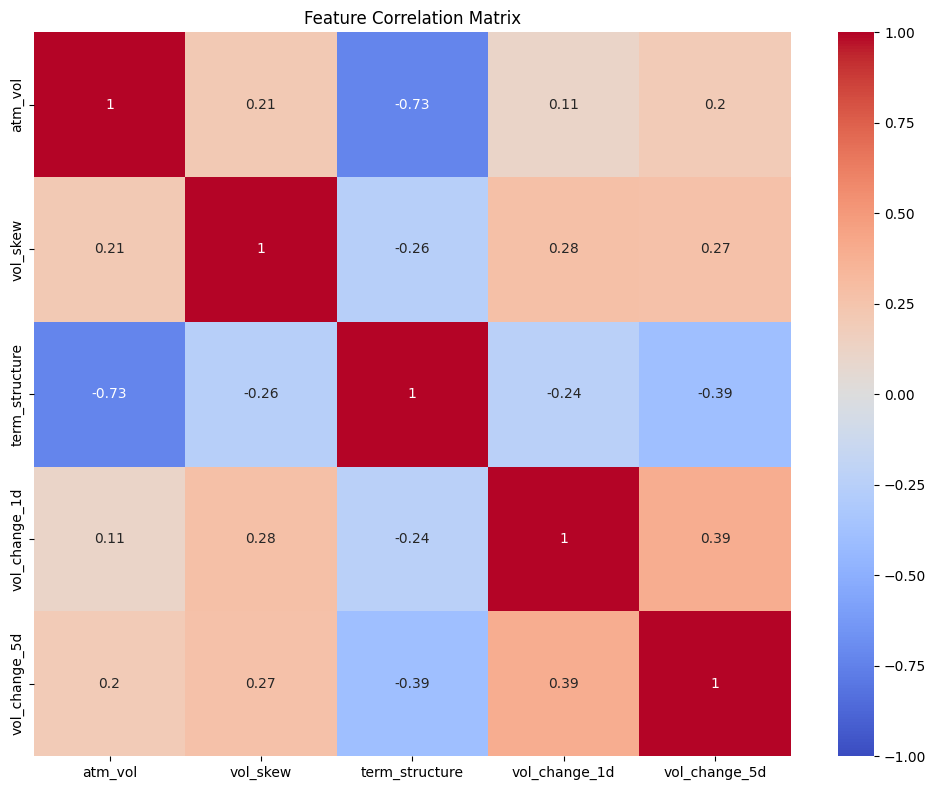


Performing Regime-Dependent Analysis...

Analyzing regime dependence for 2-Layer LSTM...

Regime-Dependent Performance:
Baseline: Alpha = -2.6253%, Beta = -0.1334
High Vol: Alpha = 16.8963%, Beta = -0.1095
Low Vol: Alpha = 4.6346%, Beta = 0.0907

Trend-Dependent Performance:
Baseline: Alpha = 3.6738%, Beta = 0.0847
Rising Vol: Alpha = 10.0210%, Beta = -0.0410
Falling Vol: Alpha = 3.5543%, Beta = -0.2883

Analyzing regime dependence for 3-Layer LSTM...

Regime-Dependent Performance:
Baseline: Alpha = -0.8239%, Beta = -0.1770
High Vol: Alpha = 19.4920%, Beta = 0.0253
Low Vol: Alpha = 7.0655%, Beta = 0.0800

Trend-Dependent Performance:
Baseline: Alpha = 0.3377%, Beta = 0.0767
Rising Vol: Alpha = 10.4602%, Beta = -0.0405
Falling Vol: Alpha = 12.5405%, Beta = -0.1625

Analyzing regime dependence for 4-Layer LSTM...

Regime-Dependent Performance:
Baseline: Alpha = -0.5723%, Beta = -0.0612
High Vol: Alpha = 16.6154%, Beta = -0.0359
Low Vol: Alpha = 2.8413%, Beta = 0.0962

Trend-Dependent Pe

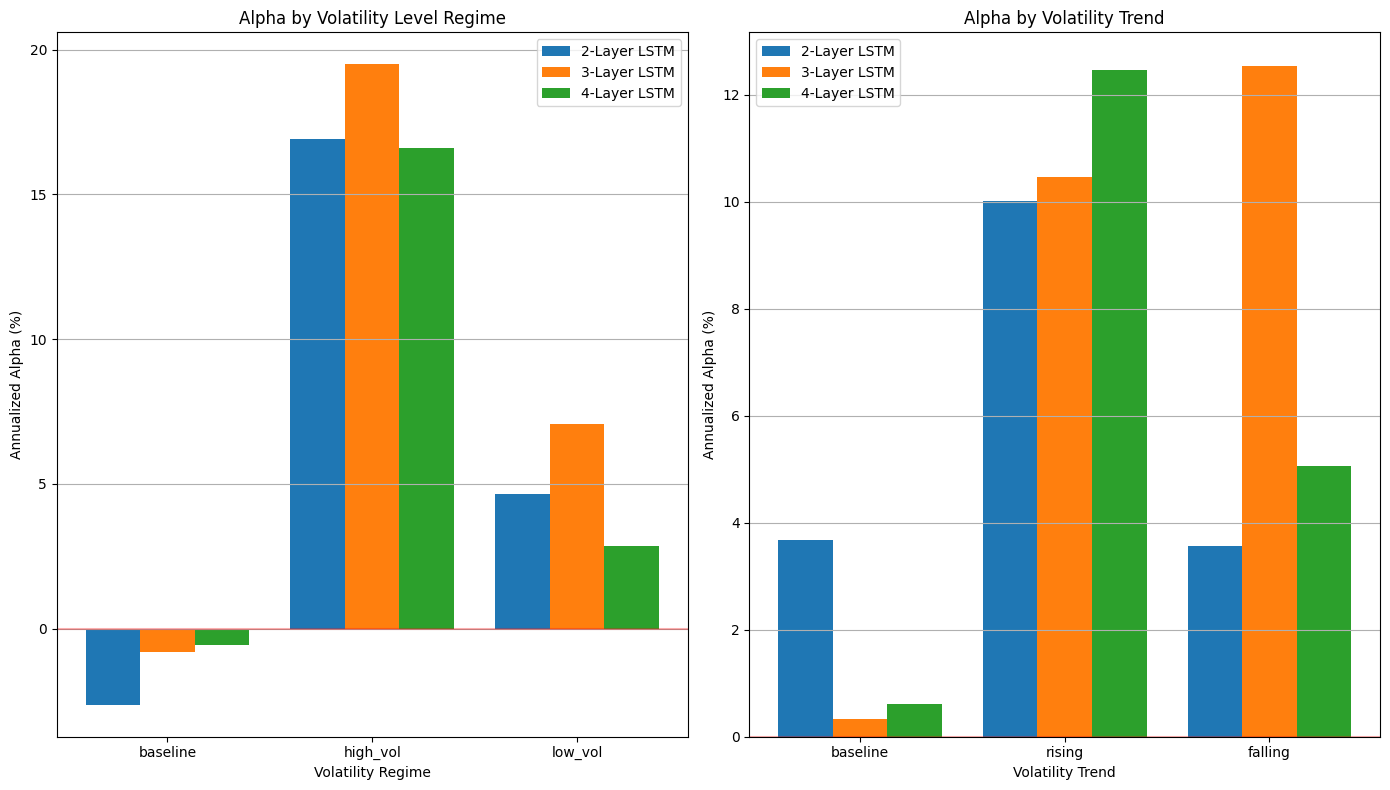


Performing Signal Persistence Analysis...

Analyzing signal persistence for 2-Layer LSTM...
Lag 1: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 2: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 3: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 4: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 5: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 6: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 7: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 8: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 9: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 10: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Signal half-life: Not determined days

Analyzing signal persistence for 3-Layer LSTM...
Lag 1: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 2: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 3: Coefficient = 0.000000, p-value = nan, R² = -0.0000
Lag 4: Coefficient = 0.000000, p-value = nan, R² = 

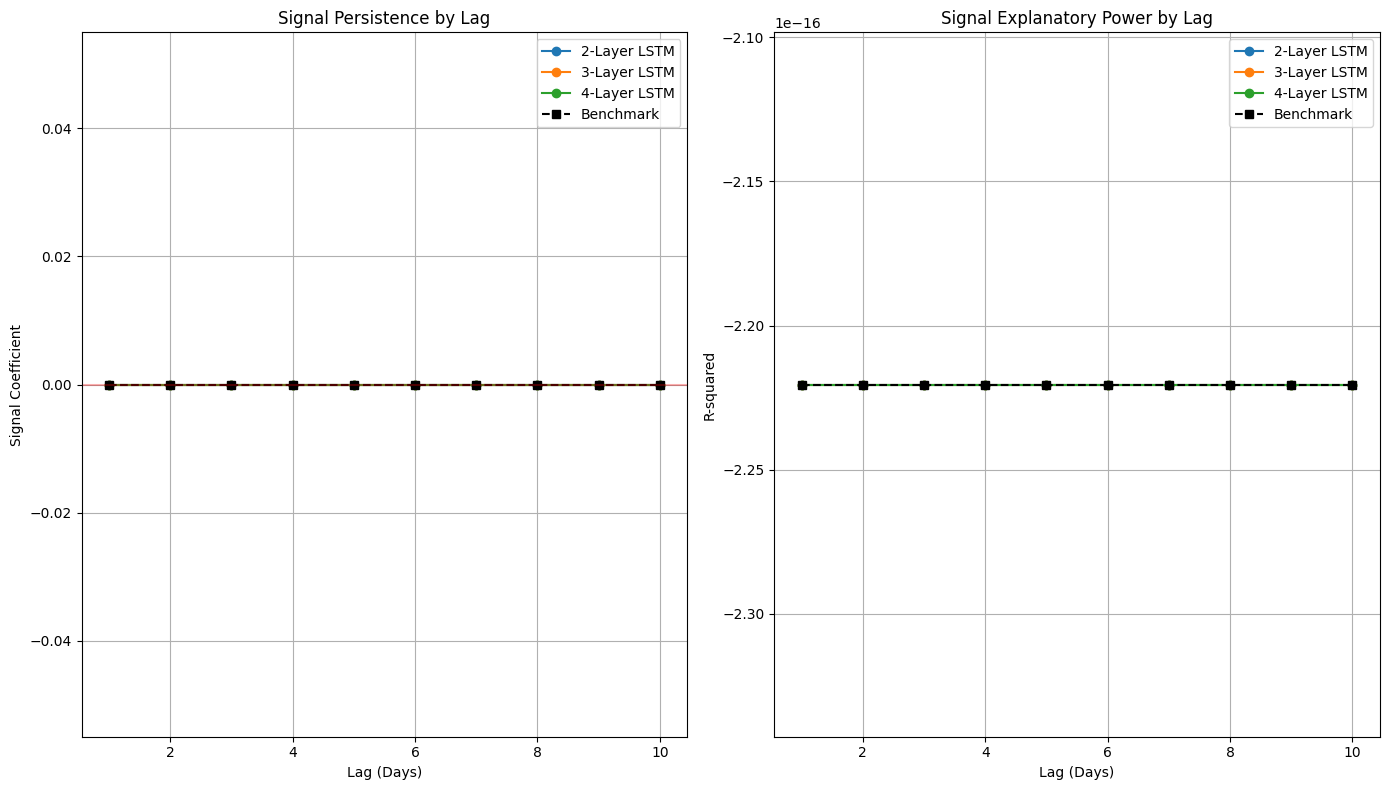


REGRESSION ANALYSIS SUMMARY

ALPHA-BETA ANALYSIS
--------------------------------------------------------------------------------
Model           Alpha (%)    p-value      Beta       R-squared   
--------------------------------------------------------------------------------
2-Layer LSTM       6.5217    0.2043       -0.0722    0.0035      
3-Layer LSTM       8.4494*   0.0986       -0.0634    0.0027      
4-Layer LSTM       6.4514    0.1872       -0.0224    0.0003      

FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------

2-Layer LSTM Feature Importance:
  Signal Model R²: nan
  Feature         Coefficient  p-value      Significance
  --------------------------------------------------
  atm_vol             0.0000 nan                      
  vol_skew            0.0000 nan                      
  term_structure      0.0000 nan                      
  vol_change_1d       0.0000 nan                      
  vol_change_5d       0.000

In [ ]:
regression_results = regression_analysis(data,
                                        lstm_results_list=[backtest_results_2layer, backtest_results_3layer, backtest_results_4layer],
                                        model_names=["2-Layer LSTM", "3-Layer LSTM", "4-Layer LSTM"],
                                        benchmark_results=benchmark_results)